In [64]:
import os
import os.path as op

import importlib
import numpy as np
from scipy.stats import pearsonr
from sklearn.cluster import KMeans

import nibabel as nib
from nilearn import datasets, image

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Patch
%matplotlib inline

from seaborn import kdeplot

import networkx as nx

import dgsp
import graph_examples as dgsp_graphs
import bimod_plots as plot

In [3]:
n_samples = 10

orig_cmap = plt.get_cmap("rainbow", n_samples)
colorlist = ["k"] + [orig_cmap(i) for i in range(n_samples)]
custom_cmap = LinearSegmentedColormap.from_list("", colorlist)

exclude = [4]
cluster_colors8 = [custom_cmap.resampled(8+1)(i+1) for i in range(8) if i not in exclude]

cmap_8clusters = LinearSegmentedColormap.from_list("", ["k"] + cluster_colors8)

## Toy Signals

In [399]:
n_per_com = 40
n_blocks = 4
com_density = 0.5
connect_density = 0.5

adj = dgsp_graphs.block_cycle(n_per_com, n_blocks=n_blocks, com_density=com_density, connect_density=connect_density)

n_cycles = 2
n_timepoints = n_cycles*n_blocks

block_signal = np.zeros((n_per_com*n_blocks, n_timepoints))
for t in range(n_timepoints):
    block = t % n_blocks

    block_signal[n_per_com*(block):n_per_com*(block+1), t] = 1

(8, 8)


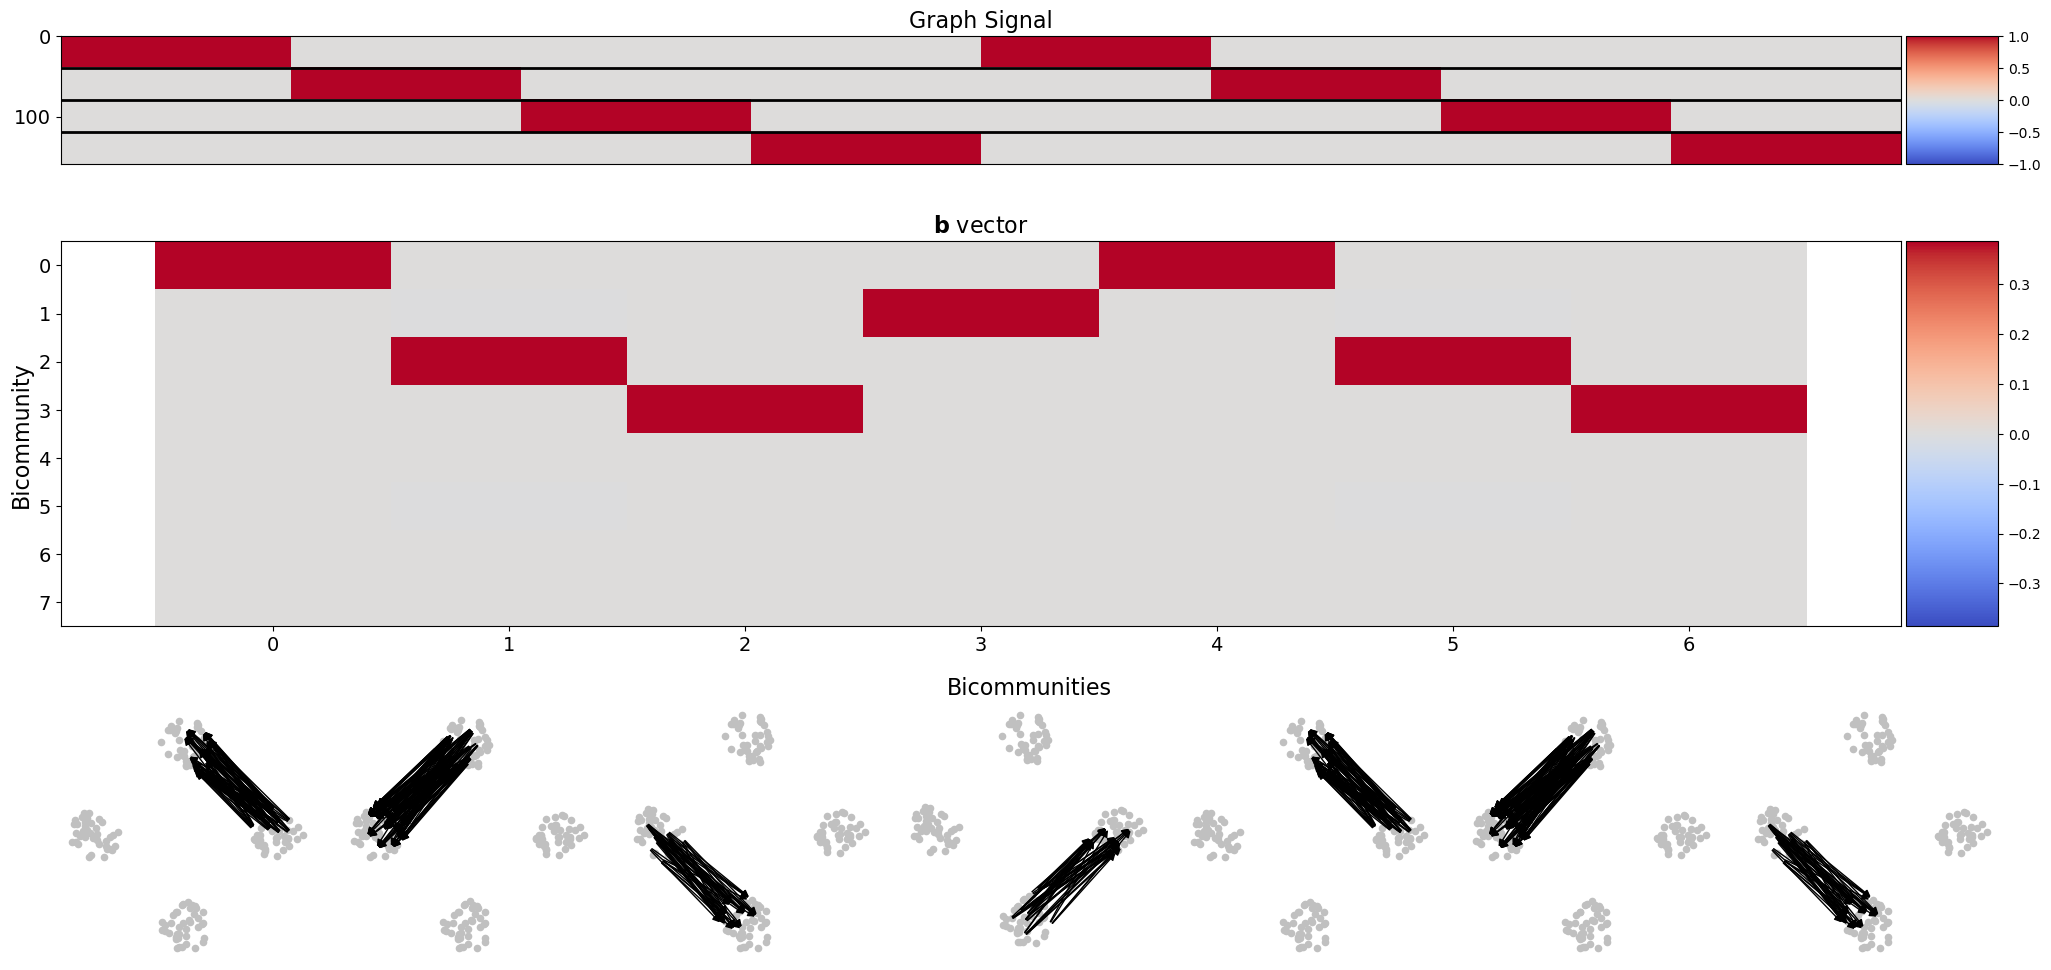

In [400]:
n_vec_max = 2
n_kmeans = 8

C_mat_out, c_pinv_out, C_mat_in, c_pinv_in, bimod_idx, _, cluster_mat  = dgsp.get_c_pinv(adj, n_vec_max, n_kmeans, normalize=False, verbose=False, return_clusters=True)

W_out = (c_pinv_out @ block_signal)
print(W_out.shape)

b_vectors = np.zeros((n_kmeans, n_timepoints - 1))
for i, w_out in enumerate(W_out.T[:-1]):
    D_mat = C_mat_in @ np.diag(w_out)
    D_pinv = np.linalg.pinv(D_mat)

    b_vectors[:, i] = D_pinv @ block_signal[:, i+1]

fig, axes = plt.subplots(nrows=3, figsize=(25, 12), gridspec_kw={"hspace":0.3, "height_ratios":[1, 3, 2]})

axes[0].set_title("Graph Signal", fontsize=16)
axes[0].imshow(block_signal, aspect="auto", cmap="coolwarm", interpolation="none", vmin=-1, vmax=1)

for k in range(3):
    axes[0].hlines((k+1)*n_per_com-1, -0.5, n_timepoints-0.5, color="k", linewidth=2)

axes[0].set_xticks([])
axes[0].tick_params(labelsize=14)
plot.add_cbar(fig, axes[0])

maxval = np.log(b_vectors.max())
minval = -maxval

axes[1].set_title("$\mathbf{b}$ vector", fontsize=16)
ax = axes[1]
ax.imshow(b_vectors, cmap="coolwarm", vmin=minval, vmax=maxval, aspect="auto", interpolation="none")

ax.tick_params(labelsize=14)
# ax.set_xlabel("Time", fontsize=16)
ax.set_xlim(-0.9, n_timepoints-1.1)
ax.set_ylabel("Bicommunity", fontsize=16)
plot.add_cbar(fig, ax)

axes[2].set_title("Bicommunities", fontsize=16)
axes[2].axis("off")
gs = GridSpecFromSubplotSpec(1, n_timepoints-1, subplot_spec=axes[2], wspace=0.1)
axes_bicom = [fig.add_subplot(gs[i]) for i in range(n_timepoints-1)]

max_com = np.argmax(b_vectors, axis=0)

circular_pos, graph_pos = plot.circular_layout(n_blocks, n_per_com, radius=2, small_radius=0.3, return_dict=True)

edge_prop = 0.3
net_red = [np.random.choice(n_per_com*n_blocks, int((1-edge_prop)*n_per_com*n_blocks), replace=False) for i in range(2)]

for i, ax in enumerate(axes_bicom):
    ax.axis("off")
    
    red_mat = cluster_mat.copy().astype(float)
    #red_mat[red_mat != max_com[i] + 1] = 0
    for k in range(n_kmeans):
        red_mat[red_mat == k+1] *= b_vectors[k, i]

    red_mat[np.abs(red_mat) < 0.1] = 0

    red_mat[net_red[0], :] = 0
    red_mat[:, net_red[1]] = 0

    ax.scatter(circular_pos[0], circular_pos[1], s=20, color="silver")#, edgecolors="k", linewidths=1, zorder=2)
    nx.draw_networkx_edges(nx.DiGraph(red_mat), pos=graph_pos, ax=ax)

### Stay in self

(8, 24)


(-1.0, 23.0)

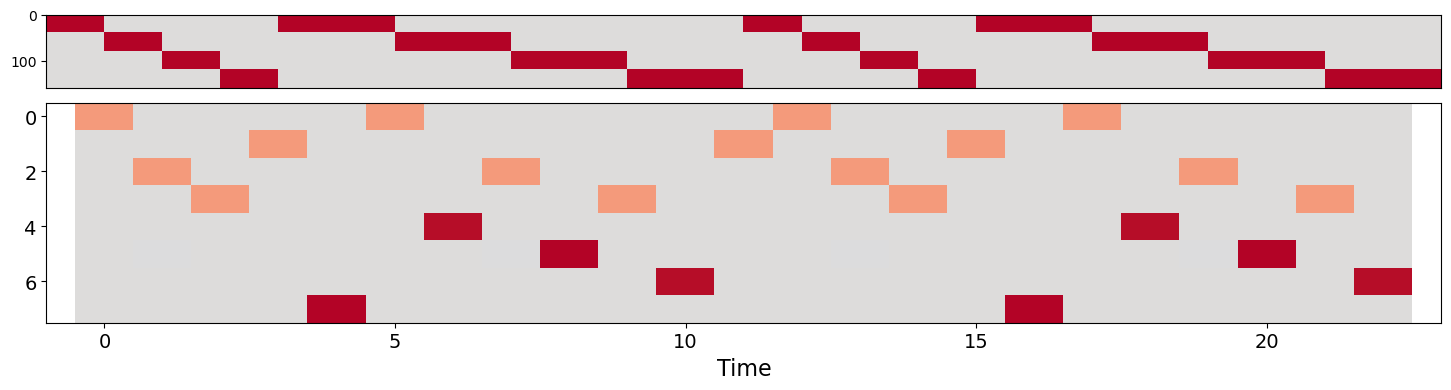

In [401]:
n_cycles = 4
n_timepoints = n_cycles*n_blocks

block_signal = np.zeros((n_per_com*n_blocks, n_timepoints))
for t in range(n_timepoints):
    block = t % n_cycles
    block_signal[n_per_com*(block):n_per_com*(block+1), t] = 1

block_one = np.zeros(n_per_com*n_blocks)
block_one[:n_per_com] = 1
for i, insrt in enumerate([5, 7, 9, 11, 16, 18, 20, 22]):
    block_signal = np.insert(block_signal, insrt, np.roll(block_one, i*n_per_com), axis=1)

n_timepoints = len(block_signal[0])

W_out = (c_pinv_out @ block_signal)
print(W_out.shape)

b_vectors = np.zeros((n_kmeans, n_timepoints - 1))
for i, w_out in enumerate(W_out.T[:-1]):
    D_mat = C_mat_in @ np.diag(w_out)
    D_pinv = np.linalg.pinv(D_mat)

    b_vectors[:, i] = D_pinv @ block_signal[:, i+1]

fig, axes = plt.subplots(nrows=2, figsize=(18, 4), gridspec_kw={"hspace":0.1, "height_ratios":[1, 3]})

axes[0].imshow(block_signal, aspect="auto", cmap="coolwarm", interpolation="none", vmin=-1, vmax=1)
axes[0].set_xticks([])

maxval = np.log(b_vectors.max())
maxval = b_vectors.max()
minval = -maxval

ax = axes[1]
ax.imshow(b_vectors, cmap="coolwarm", vmin=minval, vmax=maxval, aspect="auto", interpolation="none")

ax.tick_params(labelsize=14)
ax.set_xlabel("Time", fontsize=16)

ax.set_xlim(-1, n_timepoints-1)

### Smooth Transitions

1.6104215414916063


Text(0.5, 0, 'Time')

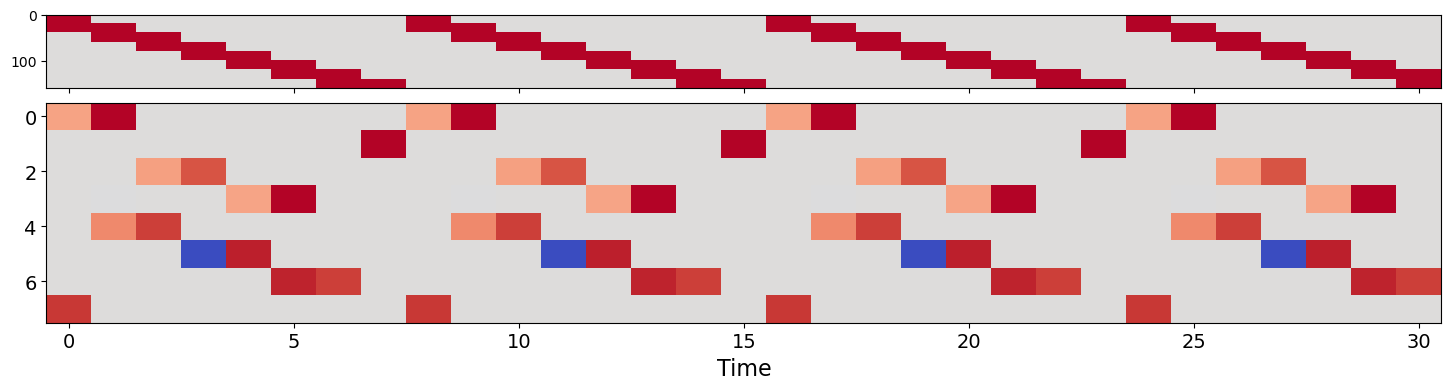

In [402]:
n_cycles = 4

overlap = 2

n_timepoints = overlap*n_cycles*n_blocks

block_signal = np.zeros((n_per_com*n_blocks, n_timepoints))
for t in range(n_timepoints):
    block = t % (overlap*n_cycles)

    block_signal[n_per_com//overlap*(block):n_per_com//overlap*(block+overlap), t] = 1

n_timepoints = len(block_signal[0])

W_out = (c_pinv_out @ block_signal)

b_vectors = np.zeros((n_kmeans, n_timepoints - 1))
for i, w_out in enumerate(W_out.T[:-1]):
    D_mat = C_mat_in @ np.diag(w_out)
    D_pinv = np.linalg.pinv(D_mat)

    b_vectors[:, i] = D_pinv @ block_signal[:, i+1]

fig, axes = plt.subplots(nrows=2, figsize=(18, 4), sharex=True, gridspec_kw={"hspace":0.1, "height_ratios":[1, 3]})

axes[0].imshow(block_signal, aspect="auto", cmap="coolwarm", interpolation="none", vmin=-1, vmax=1)

maxval = np.log(b_vectors.max())
# maxval = b_vectors.max()
minval = -maxval

print(maxval)

ax = axes[1]
ax.imshow(b_vectors, cmap="coolwarm", vmin=minval, vmax=maxval, aspect="auto", interpolation="none")

ax.tick_params(labelsize=14)
ax.set_xlabel("Time", fontsize=16)

## Concatenate

In [403]:
n_vec_max = 2
n_kmeans = 8

C_mat_out, c_pinv_out, C_mat_in, c_pinv_in, bimod_idx, _, cluster_mat  = dgsp.get_c_pinv(adj, n_vec_max, n_kmeans, normalize=False, verbose=False, return_clusters=True)

C_mat = np.concatenate([C_mat_out, C_mat_in])

n_cycles = 1
n_timepoints = n_cycles*n_blocks

block_signal = np.zeros((n_per_com*n_blocks, n_timepoints))
for t in range(n_timepoints):
    block = t % n_blocks

    block_signal[n_per_com*(block):n_per_com*(block+1), t] = 1

C_pinv = np.linalg.pinv(C_mat)
print(C_pinv.shape)

(8, 320)


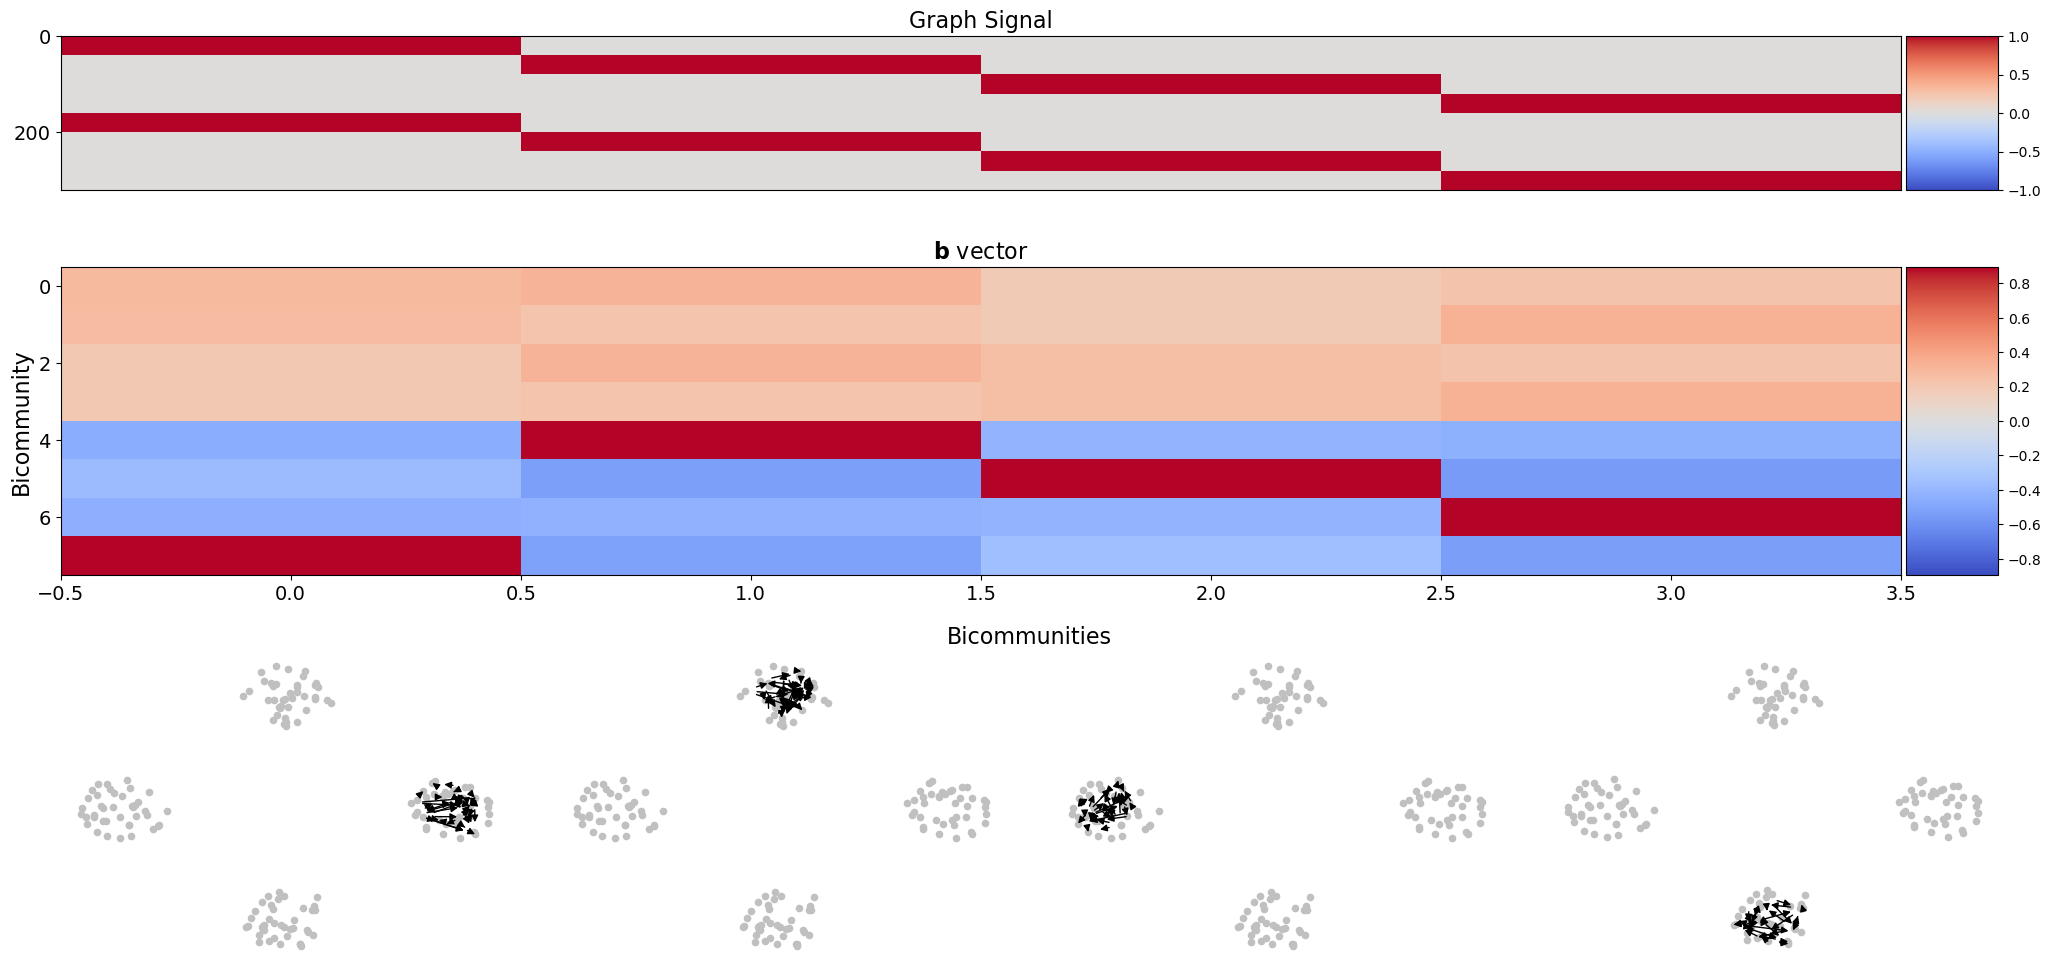

In [404]:
x_concat = np.concatenate([block_signal, block_signal]).T
proj_signals = np.array([C_pinv @ x_t for x_t in x_concat])

fig, axes = plt.subplots(nrows=3, figsize=(25, 12), gridspec_kw={"hspace":0.3, "height_ratios":[1, 2, 2]})

axes[0].set_title("Graph Signal", fontsize=16)
axes[0].imshow(x_concat.T, aspect="auto", cmap="coolwarm", interpolation="none", vmin=-1, vmax=1)

# for k in range(3):
#     axes[0].hlines((k+1)*n_per_com-1, -0.5, n_timepoints-0.5, color="k", linewidth=2)

axes[0].set_xticks([])
axes[0].tick_params(labelsize=14)
plot.add_cbar(fig, axes[0])

maxval = np.log(proj_signals.max())
minval = -maxval

axes[1].set_title("$\mathbf{b}$ vector", fontsize=16)
ax = axes[1]
ax.imshow(proj_signals.T, cmap="coolwarm", vmin=minval, vmax=maxval, aspect="auto", interpolation="none")

ax.tick_params(labelsize=14)
# ax.set_xlabel("Time", fontsize=16)
# ax.set_xlim(-0.9, n_timepoints-1.1)
ax.set_ylabel("Bicommunity", fontsize=16)
plot.add_cbar(fig, ax)

axes[2].set_title("Bicommunities", fontsize=16)
axes[2].axis("off")
gs = GridSpecFromSubplotSpec(1, n_timepoints, subplot_spec=axes[2], wspace=0.1)
axes_bicom = [fig.add_subplot(gs[i]) for i in range(n_timepoints)]

max_com = np.argmax(proj_signals, axis=1)

circular_pos, graph_pos = plot.circular_layout(n_blocks, n_per_com, radius=2, small_radius=0.3, return_dict=True)

edge_prop = 0.3
net_red = [np.random.choice(n_per_com*n_blocks, int((1-edge_prop)*n_per_com*n_blocks), replace=False) for i in range(2)]

for i, ax in enumerate(axes_bicom):
    ax.axis("off")
    
    red_mat = cluster_mat.copy().astype(float)
    red_mat[red_mat != max_com[i] + 1] = 0
    # for k in range(n_kmeans):
    #     red_mat[red_mat == k+1] *= b_vectors[k, i]

    # red_mat[np.abs(red_mat) < 0.1] = 0

    red_mat[net_red[0], :] = 0
    red_mat[:, net_red[1]] = 0

    ax.scatter(circular_pos[0], circular_pos[1], s=20, color="silver")#, edgecolors="k", linewidths=1, zorder=2)
    nx.draw_networkx_edges(nx.DiGraph(red_mat), pos=graph_pos, ax=ax)

(3, 320)


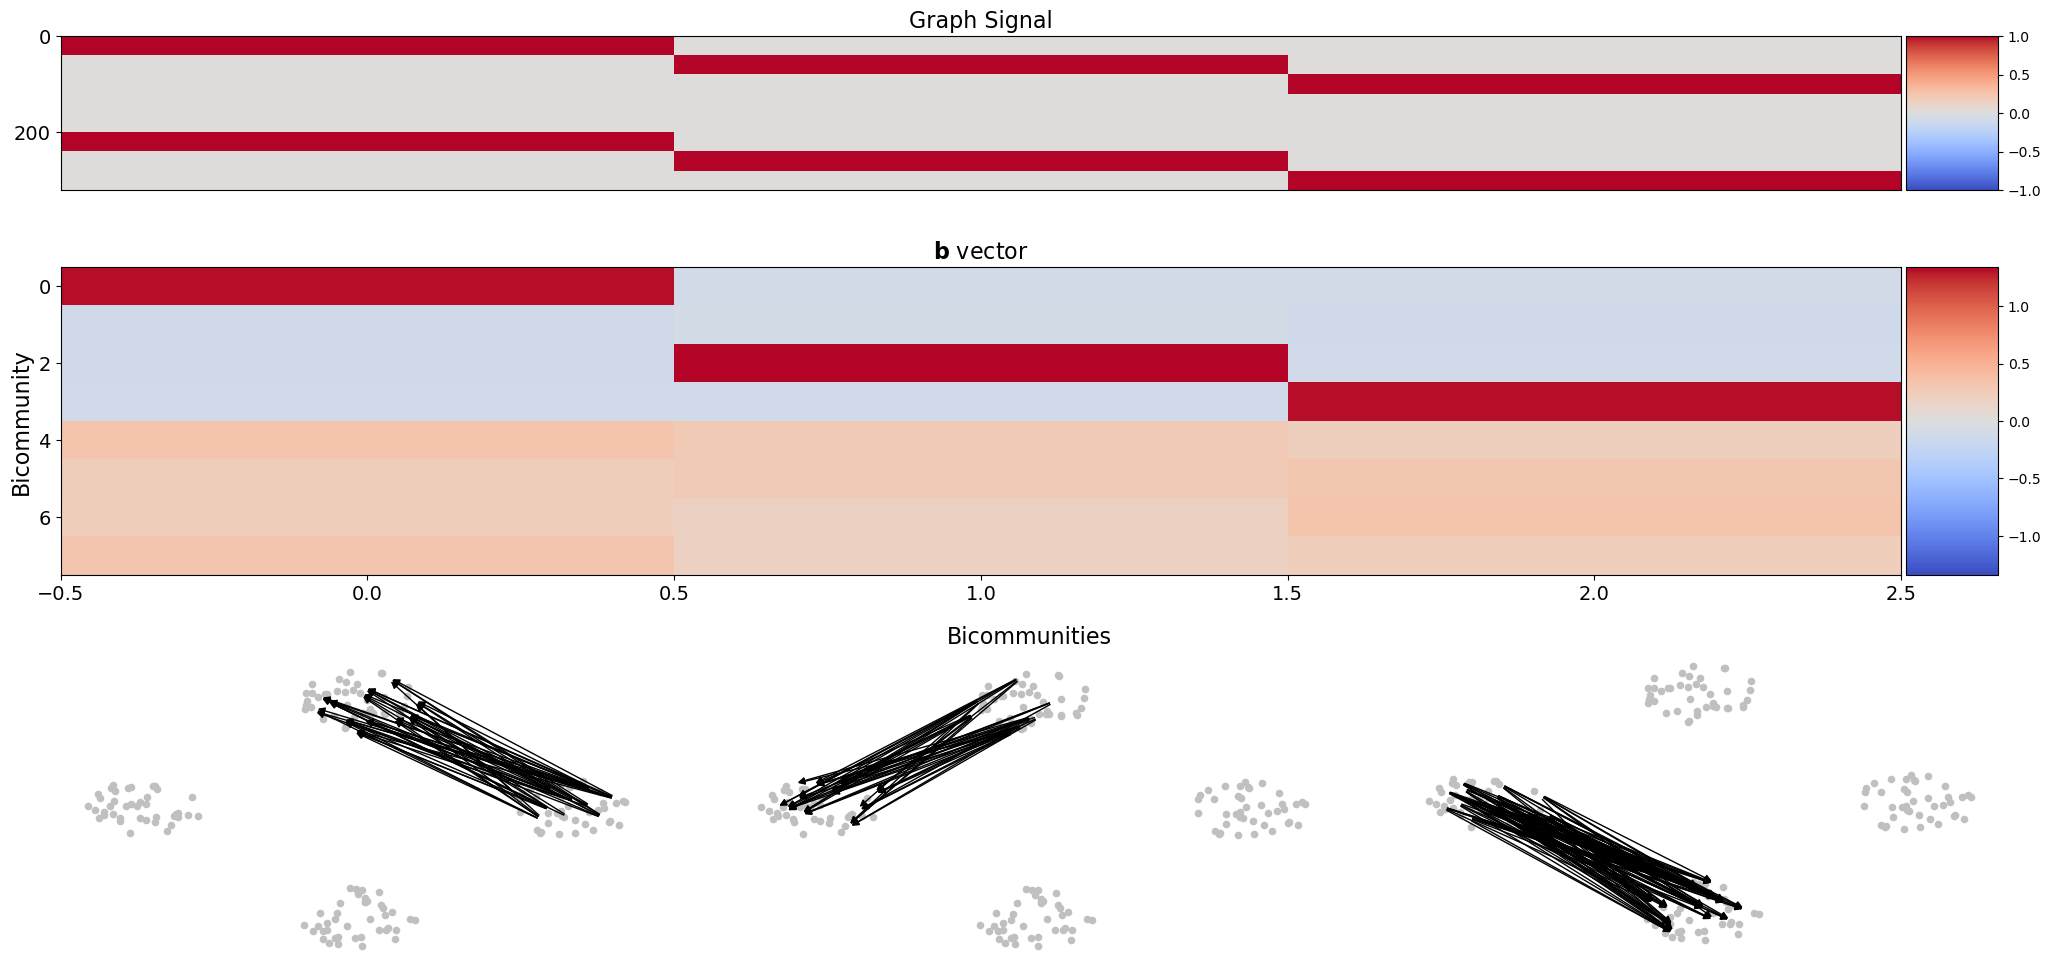

In [405]:
x_concat = np.concatenate([block_signal[:, :-1], block_signal[:, 1:]]).T
print(x_concat.shape)
proj_signals = np.array([C_pinv @ x_t for x_t in x_concat])

fig, axes = plt.subplots(nrows=3, figsize=(25, 12), gridspec_kw={"hspace":0.3, "height_ratios":[1, 2, 2]})

axes[0].set_title("Graph Signal", fontsize=16)
axes[0].imshow(x_concat.T, aspect="auto", cmap="coolwarm", interpolation="none", vmin=-1, vmax=1)

# axes[0].imshow(block_signal, aspect="auto", cmap="coolwarm", interpolation="none", vmin=-1, vmax=1)
# for k in range(3):
#     axes[0].hlines((k+1)*n_per_com-1, -0.5, n_timepoints-0.5, color="k", linewidth=2)

axes[0].set_xticks([])
axes[0].tick_params(labelsize=14)
plot.add_cbar(fig, axes[0])

maxval = proj_signals.max()
minval = -maxval

axes[1].set_title("$\mathbf{b}$ vector", fontsize=16)
ax = axes[1]
ax.imshow(proj_signals.T, cmap="coolwarm", vmin=minval, vmax=maxval, aspect="auto", interpolation="none")

ax.tick_params(labelsize=14)
# ax.set_xlabel("Time", fontsize=16)
# ax.set_xlim(-0.9, n_timepoints-1.1)
ax.set_ylabel("Bicommunity", fontsize=16)
plot.add_cbar(fig, ax)

axes[2].set_title("Bicommunities", fontsize=16)
axes[2].axis("off")
gs = GridSpecFromSubplotSpec(1, n_timepoints-1, subplot_spec=axes[2], wspace=0.1)
axes_bicom = [fig.add_subplot(gs[i]) for i in range(n_timepoints-1)]

max_com = np.argmax(proj_signals, axis=1)

circular_pos, graph_pos = plot.circular_layout(n_blocks, n_per_com, radius=2, small_radius=0.3, return_dict=True)

edge_prop = 0.3
net_red = [np.random.choice(n_per_com*n_blocks, int((1-edge_prop)*n_per_com*n_blocks), replace=False) for i in range(2)]

for i, ax in enumerate(axes_bicom):
    ax.axis("off")
    
    red_mat = cluster_mat.copy().astype(float)
    red_mat[red_mat != max_com[i] + 1] = 0
    # for k in range(n_kmeans):
    #     red_mat[red_mat == k+1] *= b_vectors[k, i]

    # red_mat[np.abs(red_mat) < 0.1] = 0

    red_mat[net_red[0], :] = 0
    red_mat[:, net_red[1]] = 0

    ax.scatter(circular_pos[0], circular_pos[1], s=20, color="silver")#, edgecolors="k", linewidths=1, zorder=2)
    nx.draw_networkx_edges(nx.DiGraph(red_mat), pos=graph_pos, ax=ax)

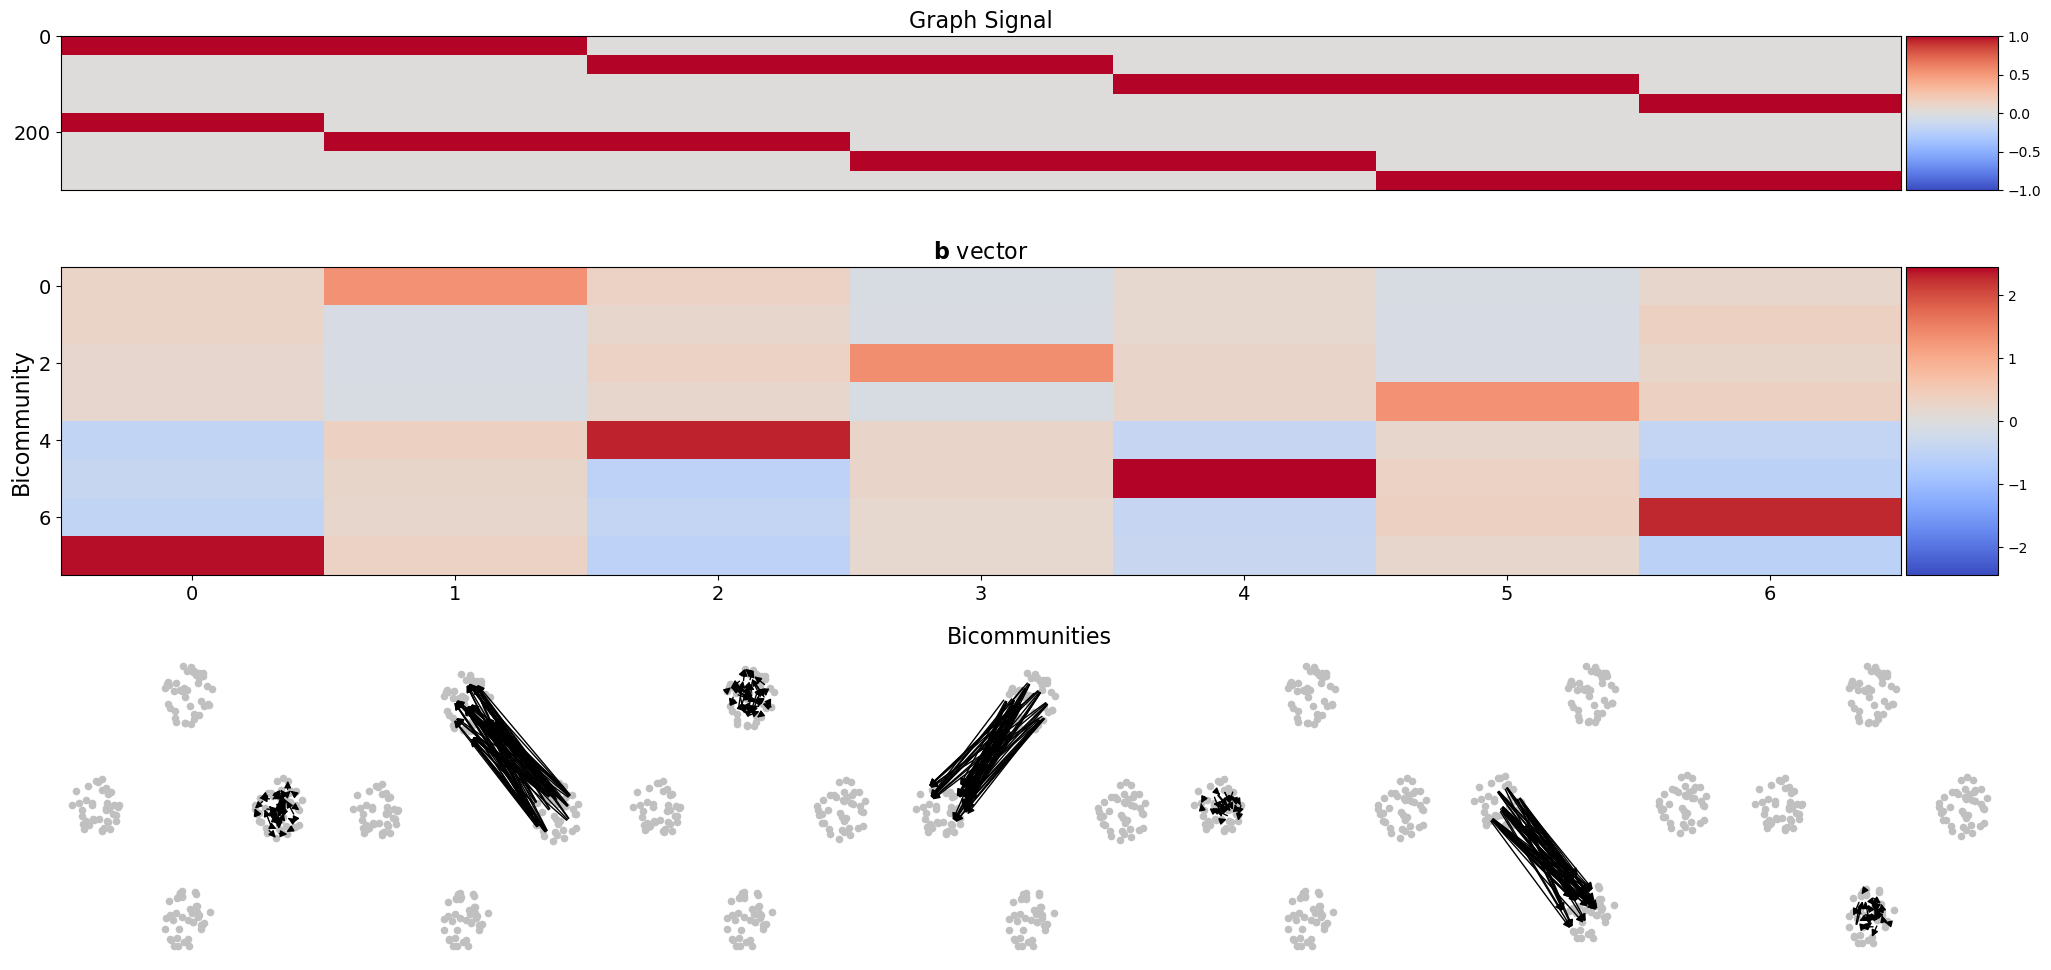

In [406]:
x_concat = np.zeros((2*n_timepoints-1, 2*len(adj)))

x_concat[::2] = np.concatenate([block_signal, block_signal]).T
x_concat[1::2] = np.concatenate([block_signal[:, :-1], block_signal[:, 1:]]).T

proj_signals = np.array([C_pinv @ x_t for x_t in x_concat])

fig, axes = plt.subplots(nrows=3, figsize=(25, 12), gridspec_kw={"hspace":0.3, "height_ratios":[1, 2, 2]})

axes[0].set_title("Graph Signal", fontsize=16)
axes[0].imshow(x_concat.T, aspect="auto", cmap="coolwarm", interpolation="none", vmin=-1, vmax=1)

# axes[0].imshow(block_signal, aspect="auto", cmap="coolwarm", interpolation="none", vmin=-1, vmax=1)
# for k in range(3):
#     axes[0].hlines((k+1)*n_per_com-1, -0.5, n_timepoints-0.5, color="k", linewidth=2)

axes[0].set_xticks([])
axes[0].tick_params(labelsize=14)
plot.add_cbar(fig, axes[0])

maxval = proj_signals.max()
minval = -maxval

axes[1].set_title("$\mathbf{b}$ vector", fontsize=16)
ax = axes[1]
ax.imshow(proj_signals.T, cmap="coolwarm", vmin=minval, vmax=maxval, aspect="auto", interpolation="none")

ax.tick_params(labelsize=14)
# ax.set_xlabel("Time", fontsize=16)
# ax.set_xlim(-0.9, n_timepoints-1.1)
ax.set_ylabel("Bicommunity", fontsize=16)
plot.add_cbar(fig, ax)

axes[2].set_title("Bicommunities", fontsize=16)
axes[2].axis("off")
gs = GridSpecFromSubplotSpec(1, 2*n_timepoints-1, subplot_spec=axes[2], wspace=0.1)
axes_bicom = [fig.add_subplot(gs[i]) for i in range(2*n_timepoints-1)]

max_com = np.argmax(proj_signals, axis=1)

circular_pos, graph_pos = plot.circular_layout(n_blocks, n_per_com, radius=2, small_radius=0.3, return_dict=True)

edge_prop = 0.3
net_red = [np.random.choice(n_per_com*n_blocks, int((1-edge_prop)*n_per_com*n_blocks), replace=False) for i in range(2)]

for i, ax in enumerate(axes_bicom):
    ax.axis("off")
    
    red_mat = cluster_mat.copy().astype(float)
    red_mat[red_mat != max_com[i] + 1] = 0
    # for k in range(n_kmeans):
    #     red_mat[red_mat == k+1] *= proj_signals.T[k, i]

    # red_mat[np.abs(red_mat) < 0.1] = 0

    red_mat[net_red[0], :] = 0
    red_mat[:, net_red[1]] = 0

    ax.scatter(circular_pos[0], circular_pos[1], s=20, color="silver")#, edgecolors="k", linewidths=1, zorder=2)
    nx.draw_networkx_edges(nx.DiGraph(red_mat), pos=graph_pos, ax=ax)

## Using $\mathbf{U}$ and $\mathbf{V}$

(160, 4)
(20, 320)
[2.68672757e-02 8.59907465e-15]
C_pinv is the transpose of C_mat


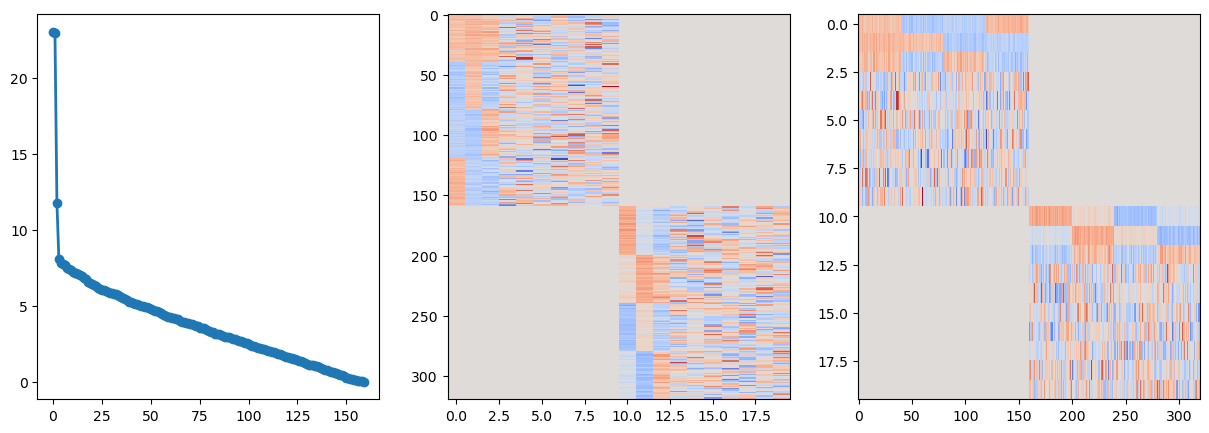

In [849]:
n_cycles = 1
overlap = 1

n_timepoints = overlap*n_cycles*n_blocks

block_signal = np.zeros((n_per_com*n_blocks, n_timepoints))
for t in range(n_timepoints):
    block = t % (overlap*n_blocks)

    block_signal[n_per_com//overlap*(block):n_per_com//overlap*(block+overlap), t] = 1

print(block_signal.shape)
block_signal = np.insert(block_signal, len(block_signal[0]), np.roll(block_signal[:, 0], 2*n_per_com), axis=1)
# block_signal = np.insert(block_signal, 4, np.roll(block_signal[:, 0], 2*n_per_com), axis=1)
# block_signal = np.insert(block_signal, 4, np.roll(block_signal[:, 0], 2*n_per_com), axis=1)
# block_signal = np.insert(block_signal, 6, np.roll(block_signal[:, 0], 1*n_per_com), axis=1)
# block_signal = np.insert(block_signal, 7, np.roll(block_signal[:, 0], 3*n_per_com), axis=1)

block_signal = block_signal[:, :2]

n_timepoints = len(block_signal[0])

n_nodes = len(adj)
U, S, Vh = dgsp.sorted_SVD(dgsp.modularity_matrix(adj))
V = Vh.T

n_concat = len(adj)
n_concat = 150

n_min = 0
n_max = 10

uk = U[:, n_min:n_max]
vk = V[:, n_min:n_max]

# uk = np.concatenate([uk, U[:, -1][None].T], axis=1)
# vk = np.concatenate([vk, V[:, -1][None].T], axis=1)

K = len(uk[0])

C_mat = np.block([[uk, np.zeros_like(vk)],
                  [np.zeros_like(uk), vk]])
C_pinv = np.linalg.pinv(C_mat)
print(C_pinv.shape)

fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

axes[0].plot(S, "-o", lw=2)
print(S[-2:])

axes[1].imshow(C_mat, aspect="auto", cmap="coolwarm", interpolation="none")
# plot.add_cbar(fig, axes[1])

axes[2].imshow(C_pinv, aspect="auto", cmap="coolwarm", interpolation="none")
# plot.add_cbar(fig, axes[2])

if np.allclose(C_pinv, C_mat.T):
    print("C_pinv is the transpose of C_mat")

(3, 320)


(<Figure size 2500x1200 with 6 Axes>,
 <Axes: title={'center': '$\\hat{{\\mathbf{x}}}_t$, for $t=1,\\ldots,T-1$'}>,
 <matplotlib.colorbar.Colorbar at 0x3470c13d0>)

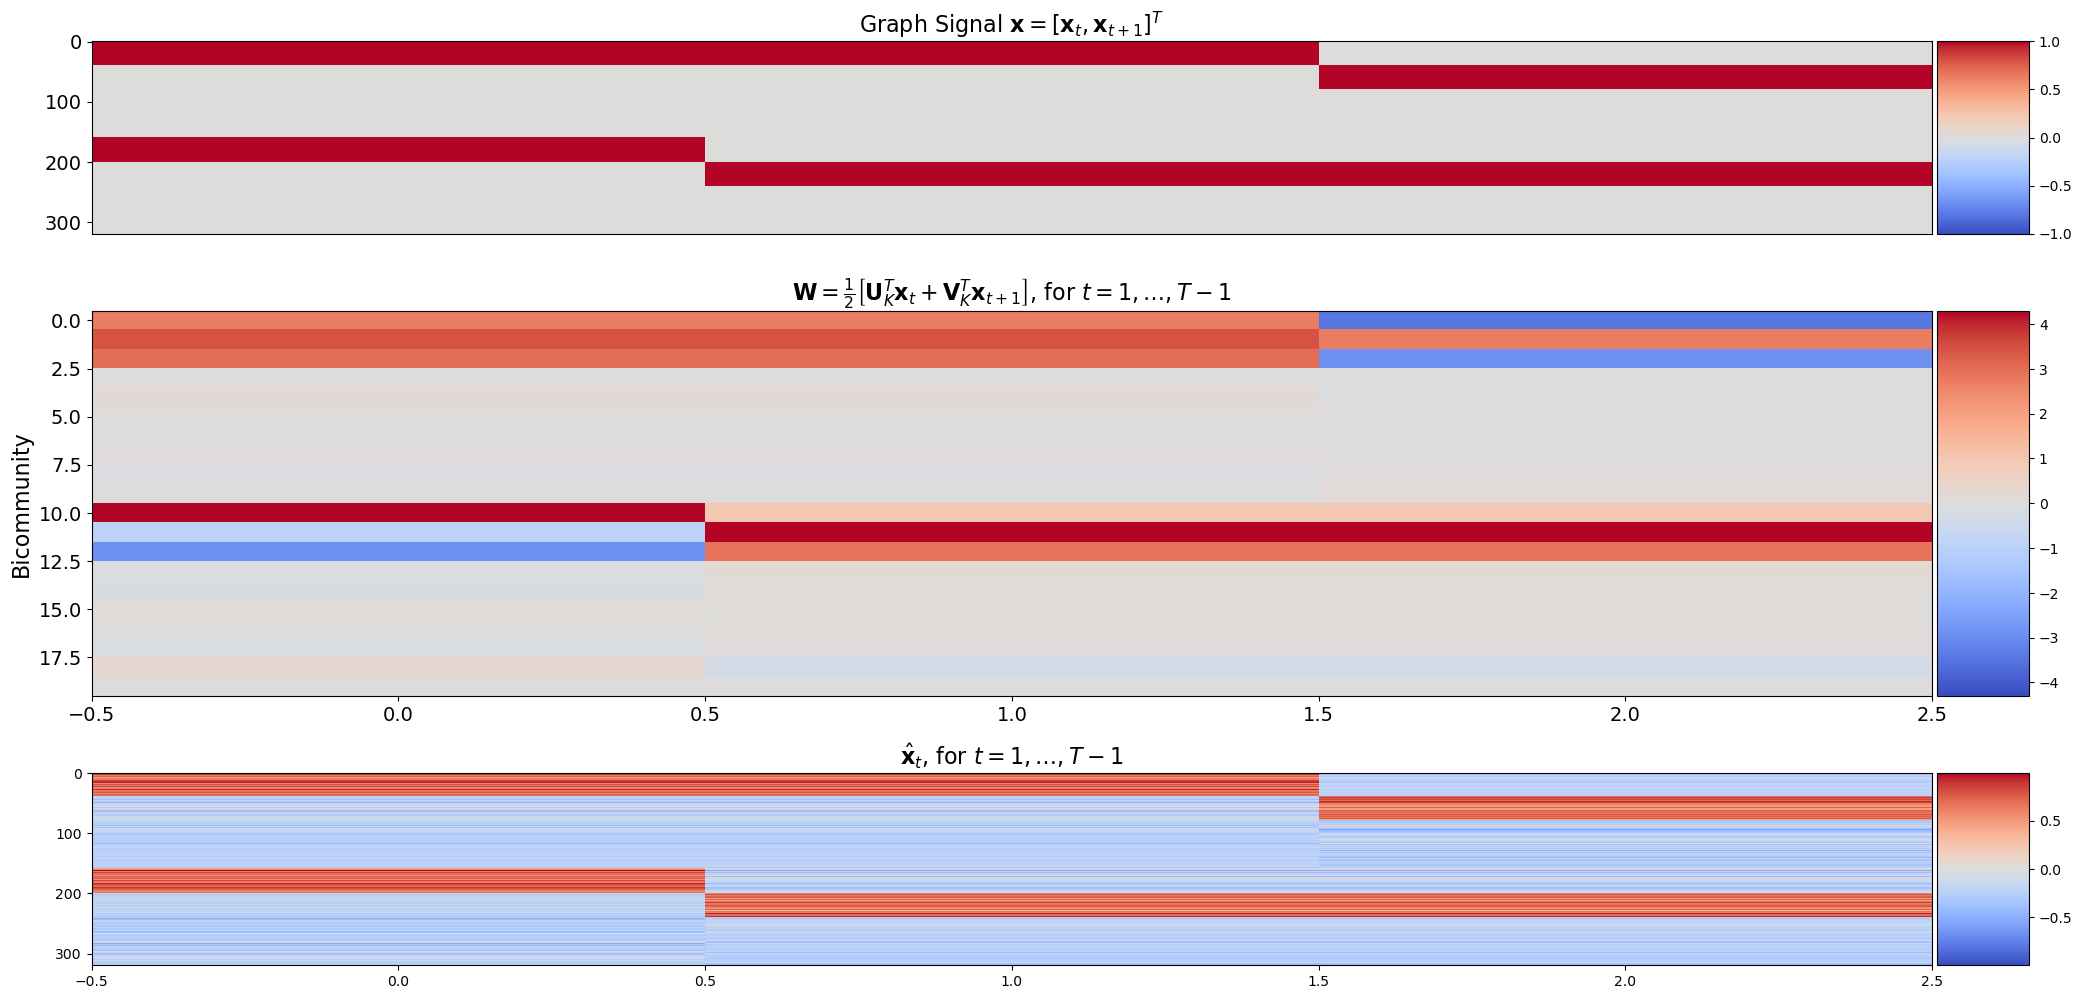

In [850]:
# x_concat = np.concatenate([block_signal, block_signal]).T

x_concat = np.zeros((2*n_timepoints-1, 2*len(adj)))
print(x_concat.shape)
x_concat[::2] = np.concatenate([block_signal, block_signal], axis=0).T
x_concat[1::2] = np.concatenate([block_signal[:, :-1], block_signal[:, 1:]], axis=0).T

# x_concat = x_concat - x_concat.mean(axis=1, keepdims=True)

proj_signals = np.array([C_pinv @ x_t for x_t in x_concat])

fig, axes = plt.subplots(nrows=3, figsize=(25, 12), gridspec_kw={"hspace":0.3, "height_ratios":[1, 2, 1]})

axes[0].set_title("Graph Signal $\mathbf{x}=\left[\mathbf{x}_{t}, \mathbf{x}_{t+1}\\right]^T$", fontsize=16)
axes[0].imshow(x_concat.T, aspect="auto", cmap="coolwarm", interpolation="none", vmin=-1, vmax=1)

axes[0].set_xticks([])
axes[0].tick_params(labelsize=14)
plot.add_cbar(fig, axes[0])

maxval = proj_signals.max()
minval = -maxval

axes[1].set_title("$\mathbf{W}=\\frac{1}{2}\left[\mathbf{U}^{T}_{K}\mathbf{x}_{t}+\mathbf{V}^{T}_{K}\mathbf{x}_{t+1}\\right]$"
                  ", for $t=1,\ldots,T-1$", fontsize=16)
ax = axes[1]
ax.imshow(proj_signals.T, cmap="coolwarm", vmin=minval, vmax=maxval, aspect="auto", interpolation="none")

ax.tick_params(labelsize=14)
ax.set_ylabel("Bicommunity", fontsize=16)
plot.add_cbar(fig, ax)

reconstructions = np.array([C_mat @ proj for proj in proj_signals])

maxval = reconstructions.max()
axes[2].set_title("$\hat{{\mathbf{x}}}_t$, for $t=1,\ldots,T-1$", fontsize=16)
axes[2].imshow(reconstructions.T, cmap="coolwarm", vmin=-maxval, vmax=maxval, aspect="auto", interpolation="none")
plot.add_cbar(fig, axes[2])

(3, 20)


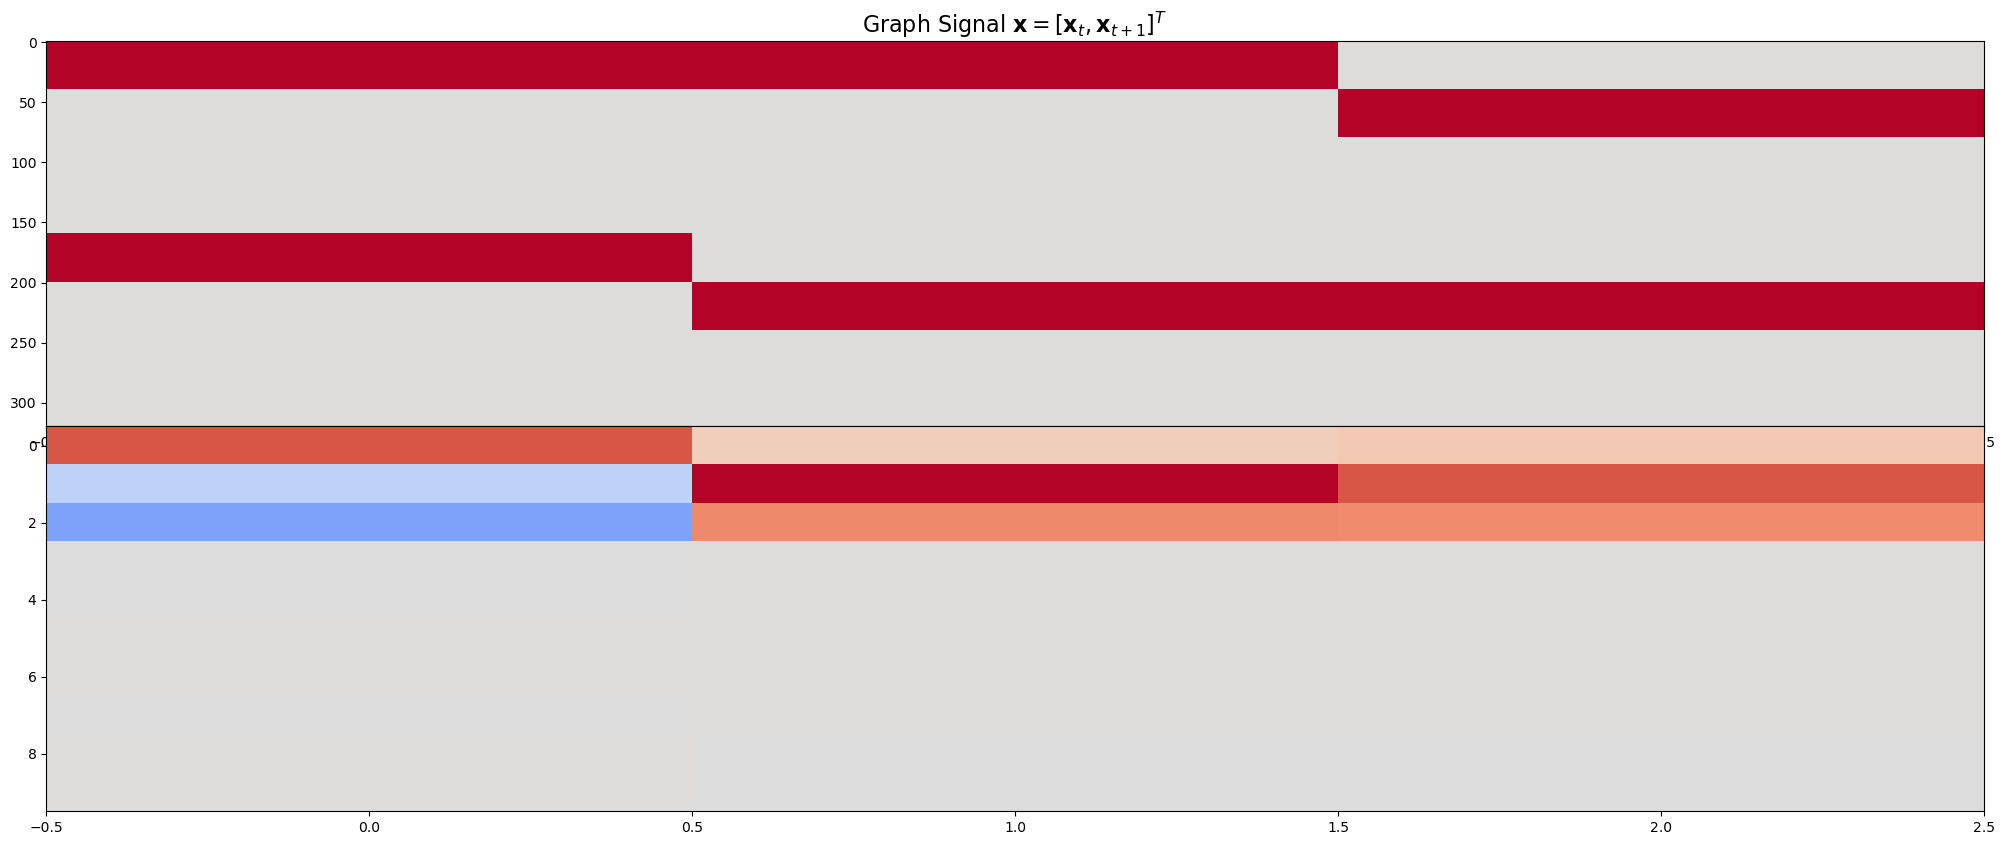

In [851]:
print(proj_signals.shape)

proj_prod = proj_signals[:, :K] * proj_signals[:, K:]
proj_prod *= np.sign(proj_signals[:, :K])
maxval = proj_prod.max()

fig, axes = plt.subplots(nrows=2, figsize=(25, 10), gridspec_kw={"hspace":0, "height_ratios":[1, 1]})

axes[0].set_title("Graph Signal $\mathbf{x}=\left[\mathbf{x}_{t}, \mathbf{x}_{t+1}\\right]^T$", fontsize=16)
axes[0].imshow(x_concat.T, aspect="auto", cmap="coolwarm", interpolation="none", vmin=-1, vmax=1)

axes[1].imshow(proj_prod.T, aspect="auto", cmap="coolwarm", vmin=-maxval, vmax=maxval, interpolation="none")

(3, 20)
(320, 20)
(20, 20, 3)
(20, 320, 3)


(<Figure size 2000x500 with 5 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x346f152d0>)

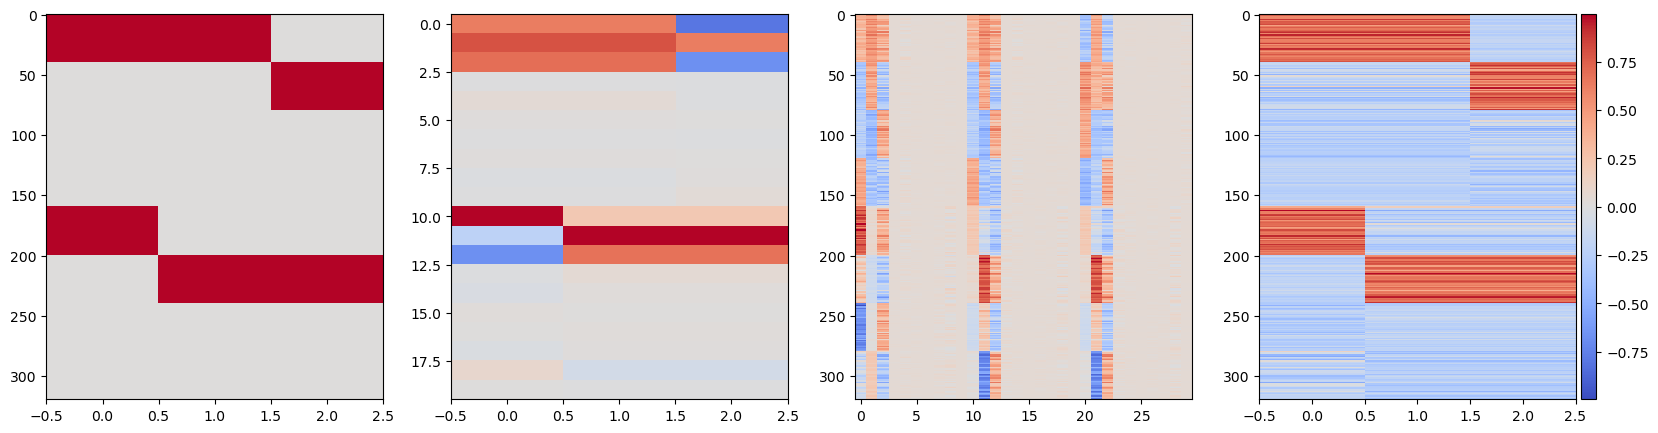

In [852]:
print(proj_signals.shape)
print(C_mat.shape)
proj_diag = np.array([np.diag(proj) for proj in proj_signals]).T
print(proj_diag.shape)

# scale_S = np.concatenate([S[n_min:n_max]]*2)
# scale_S = np.ones_like(scale_S)
# proj_diag = np.diag(scale_S) @ proj_diag

C_rec = C_mat @ proj_diag
manual_C_rec = np.array([C_mat @ diag for diag in proj_diag.T])

print(C_rec.shape)

fig, axes = plt.subplots(ncols=4, figsize=(20, 5))

axes[0].imshow(x_concat.T, aspect="auto", cmap="coolwarm", interpolation="none", vmin=-1, vmax=1)

axes[1].imshow(proj_signals.T, aspect="auto", cmap="coolwarm", interpolation="none", vmin=-proj_signals.max(), vmax=proj_signals.max())

C_rec_pertime = np.zeros((K, 2*n_nodes, len(x_concat)))
C_rec_pertime[:, :n_nodes] = C_rec[:K, :n_nodes]
C_rec_pertime[:, n_nodes:] = C_rec[K:, n_nodes:]
C_rec_pertime = np.moveaxis(C_rec_pertime, (1, 0), (0, 2))

# axes[2].imshow(C_rec[..., 0].T, aspect="auto", cmap="coolwarm", interpolation="none")
axes[2].imshow(C_rec_pertime.reshape((2*n_nodes, -1)), aspect="auto", cmap="coolwarm", interpolation="none")

rec = C_rec.sum(axis = 0)
axes[3].imshow(rec, aspect="auto", cmap="coolwarm", interpolation="none", vmin=-np.abs(rec).max(), vmax=np.abs(rec).max())
plot.add_cbar(fig, axes[3])

(160, 160, 3)
(25600, 3)
(3, 4760)


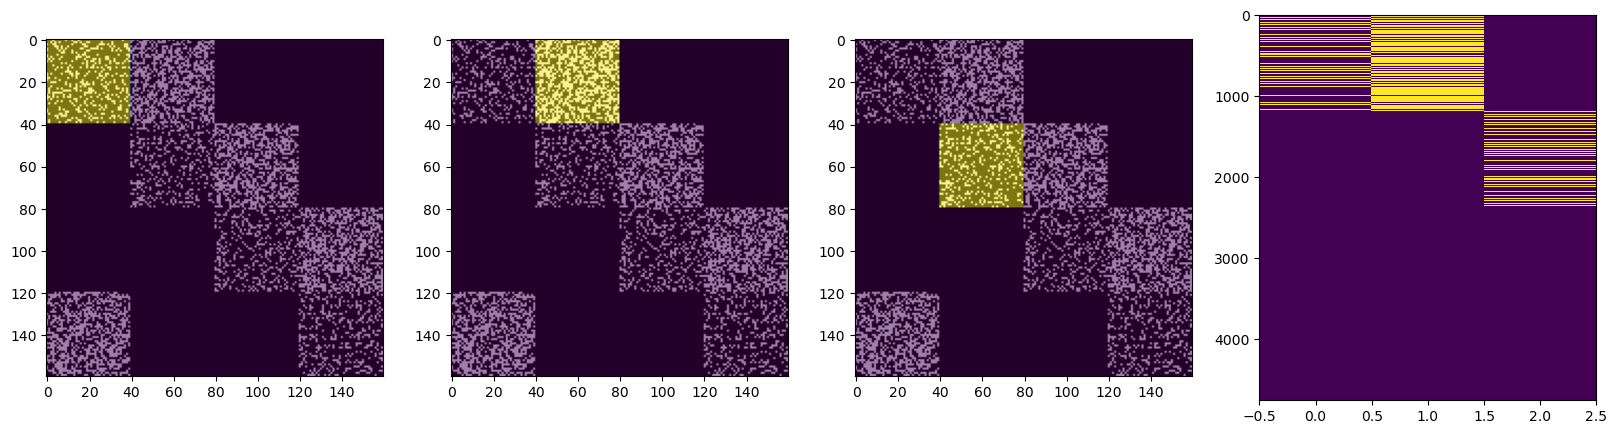

In [853]:
sendreceive_sig = np.array([x_concat[:, n_nodes:].T]*n_nodes) * np.swapaxes(np.array([x_concat[:, :n_nodes].T]*n_nodes), 0, 1)

print(sendreceive_sig.shape)

fig, axes = plt.subplots(ncols=sendreceive_sig.shape[-1]+1, figsize=(20, 5))

for i, ax in enumerate(axes[:-1]):
    ax.imshow(sendreceive_sig[..., i])
    ax.imshow(adj, cmap="gray", alpha=0.5)

sendreceive_sig_vec = sendreceive_sig.reshape((-1, sendreceive_sig.shape[-1]))
print(sendreceive_sig_vec.shape)
sendreceive_sig_vec = sendreceive_sig_vec[(adj != 0).reshape(-1)].T
print(sendreceive_sig_vec.shape)

axes[-1].imshow(sendreceive_sig_vec.T, aspect="auto", interpolation="none")

(20, 320, 3)
Orig (320, 20)
(160, 3, 10)
Orig (160, 10)
Orig (160, 160, 10)
(160, 160, 3, 10)
(160, 160, 3, 10)
(160, 160, 3, 20)
Orig (160, 160, 20)
(20, 3, 4760)
Orig (20, 4760)


Text(0, 0.5, 'Edges')

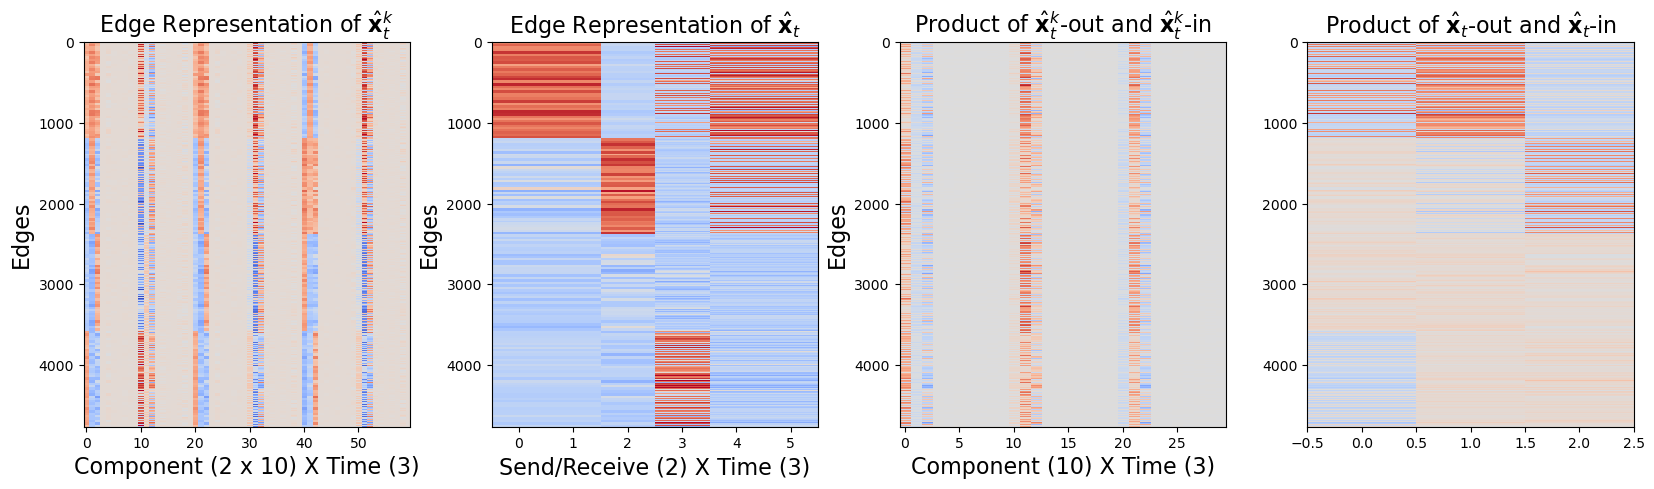

In [867]:
print(C_rec.shape)
print("Orig", C_mat.shape)

u_features = np.swapaxes(np.swapaxes(C_rec[:K, :n_nodes], 0, 1), 1, 2)
v_features = np.swapaxes(np.swapaxes(C_rec[K:, n_nodes:], 0, 1), 1, 2)
print(u_features.shape)

u_orig = C_mat[:n_nodes, :K]
v_orig = C_mat[n_nodes:, K:]
print("Orig", u_orig.shape)

orig_out = np.moveaxis(np.array([u_orig] * n_nodes), 0, 1)#.T
# orig_in = np.moveaxis(np.array([v_orig] * n_nodes), 0, 1)#.T
# orig_in = np.moveaxis(np.array([v_orig] * n_nodes), 0, 1)#.T
orig_in = np.array([u_orig] * n_nodes)#.T
print("Orig", orig_out.shape)

edge_out = np.array([u_features] * n_nodes)#.T
edge_out = np.moveaxis(edge_out, 1, 0)
print(edge_out.shape)
edge_in = np.array([v_features] * n_nodes)
# edge_in = np.moveaxis(edge_in, 1, 0)
print(edge_in.shape)

# edge-based clustering
edge_assignments = np.concatenate([edge_out, edge_in], axis=3)
print(edge_assignments.shape)

orig_assignments = np.concatenate([orig_out, orig_in], axis=2)
print("Orig", orig_assignments.shape)

# edge_assignments_vec = edge_assignments.reshape((-1, 2*K, 2*n_timepoints-1)).T
edge_assignments_vec = edge_assignments.reshape((-1, 2*n_timepoints-1, 2*K)).T
edge_assignments_vec = edge_assignments_vec[..., (adj != 0).reshape(-1)]
print(edge_assignments_vec.shape)

orig_vec = orig_assignments.reshape((-1, 2*K)).T
orig_vec = orig_vec[..., (adj != 0).reshape(-1)]
print("Orig", orig_vec.shape)

fig, axes = plt.subplots(ncols=4, figsize=(20, 5), gridspec_kw={"wspace":0.25})

axes[0].set_title(f"Edge Representation of $\\hat{{\\mathbf{{x}}}}^k_t$", fontsize=16)
axes[0].imshow(np.moveaxis(edge_assignments_vec, 0, 1).reshape((-1, (adj != 0).sum())).T,
               aspect="auto", cmap="coolwarm", interpolation="none")
axes[0].set_xlabel(f"Component (2 x {K}) X Time ({len(x_concat)})", fontsize=16)
axes[0].set_ylabel("Edges", fontsize=16)

edge_recon = edge_assignments_vec.reshape((2, K, len(x_concat), -1)).sum(axis=1).reshape((-1, (adj != 0).sum())).T
axes[1].set_title(f"Edge Representation of $\\hat{{\\mathbf{{x}}}}_t$", fontsize=16)
axes[1].imshow(edge_recon, aspect="auto", cmap="coolwarm", interpolation="none",
               vmin=-np.abs(edge_recon).max(), vmax=np.abs(edge_recon).max())
axes[1].set_xlabel(f"Send/Receive (2) X Time ({len(x_concat)})", fontsize=16)
axes[1].set_ylabel("Edges", fontsize=16)

mytime = 0

prod = edge_assignments_vec.reshape((2, K, len(x_concat), -1)).sum(axis=1)[0] * edge_assignments_vec.reshape((2, K, len(x_concat), -1)).sum(axis=1)[1]

axes[3].set_title(f"Product of $\\hat{{\\mathbf{{x}}}}_t$-out and $\\hat{{\\mathbf{{x}}}}_t$-in",
                  fontsize=16)
axes[3].imshow(prod.T, aspect="auto", cmap="coolwarm", interpolation="none",
               vmin=-np.abs(prod).max(), vmax=np.abs(prod).max())
# axes[2].scatter(edge_assignments_vec.reshape((2, K, len(x_concat), -1)).sum(axis=1)[0, mytime],
#                 edge_assignments_vec.reshape((2, K, len(x_concat), -1)).sum(axis=1)[1, mytime],
#                 c=prod, alpha=0.5, edgecolor="none", cmap="coolwarm", vmin=-1.5, vmax=1.5)
#                 # c=edge_assignments_vec.sum(axis=0)[mytime], alpha=0.5, edgecolor="none", cmap="coolwarm", vmin=-1.5, vmax=1.5)
# axes[2].set_xlabel("Send/Receive (2) X Time (3)", fontsize=16)
# axes[2].set_ylabel("Edges", fontsize=16)

# axes[3].imshow(sendreceive_sig_vec.T, aspect="auto", interpolation="none")

prod_per_k = edge_assignments_vec[:K] * edge_assignments_vec[K:]
axes[2].set_title(f"Product of $\\hat{{\\mathbf{{x}}}}^k_t$-out and $\\hat{{\\mathbf{{x}}}}^k_t$-in",
                  fontsize=16)
axes[2].imshow(np.moveaxis(prod_per_k, 0, 1).reshape((K*len(x_concat), -1)).T,
               aspect="auto", cmap="coolwarm", interpolation="none",
               vmax=np.abs(prod_per_k).max(), vmin=-np.abs(prod_per_k).max())
axes[2].set_xlabel(f"Component ({K}) X Time ({len(x_concat)})", fontsize=16)
axes[2].set_ylabel("Edges", fontsize=16)

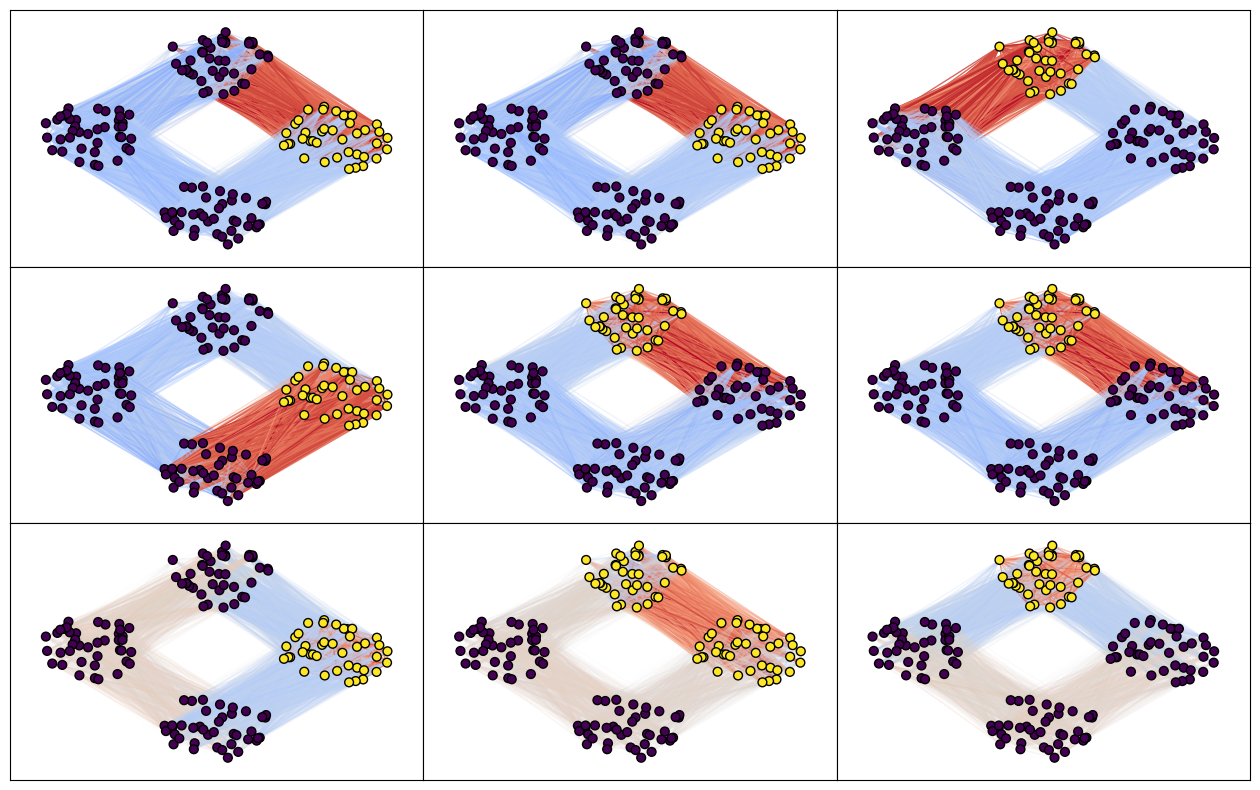

In [855]:
fig, axes = plt.subplots(nrows=3, ncols=len(x_concat), figsize=(16, 10), gridspec_kw={"hspace":0, "wspace":0})

circular_pos, graph_pos = plot.circular_layout(n_blocks, n_per_com, radius=2, small_radius=0.8, return_dict=True)
edge_cmap = plt.get_cmap("coolwarm")
edge_list = nx.DiGraph(adj).edges()

for t, ax in enumerate(axes.T):
    edge_sig = edge_assignments_vec.sum(axis=0)[t]

    node_sigs = [x_concat[t][:n_nodes], x_concat[t][n_nodes:], x_concat[t][:n_nodes] + x_concat[t][n_nodes:]]
    edge_sigs = [edge_assignments_vec.reshape((2, K, len(x_concat), -1)).sum(axis=1)[0, t],
                 edge_assignments_vec.reshape((2, K, len(x_concat), -1)).sum(axis=1)[1, t],
                 edge_assignments_vec.reshape((2, K, len(x_concat), -1)).sum(axis=1)[0, t] * edge_assignments_vec.reshape((2, K, len(x_concat), -1)).sum(axis=1)[1, t]]
    for a, node, edge in zip(ax, node_sigs, edge_sigs):
        alphas = np.abs(edge).astype(float)
        # alphas = edge ** 2
        alphas = alphas/alphas.max()
        
        a.scatter(circular_pos[0], circular_pos[1], s=40, c=node, edgecolors="k", linewidths=1, zorder=2)
        nx.draw_networkx_edges(nx.Graph(adj), pos=graph_pos, ax=a, alpha=alphas,
                               edge_color=edge, edge_cmap=edge_cmap, edgelist=edge_list,
                               edge_vmin=-np.abs(edge).max(), edge_vmax=np.abs(edge).max())

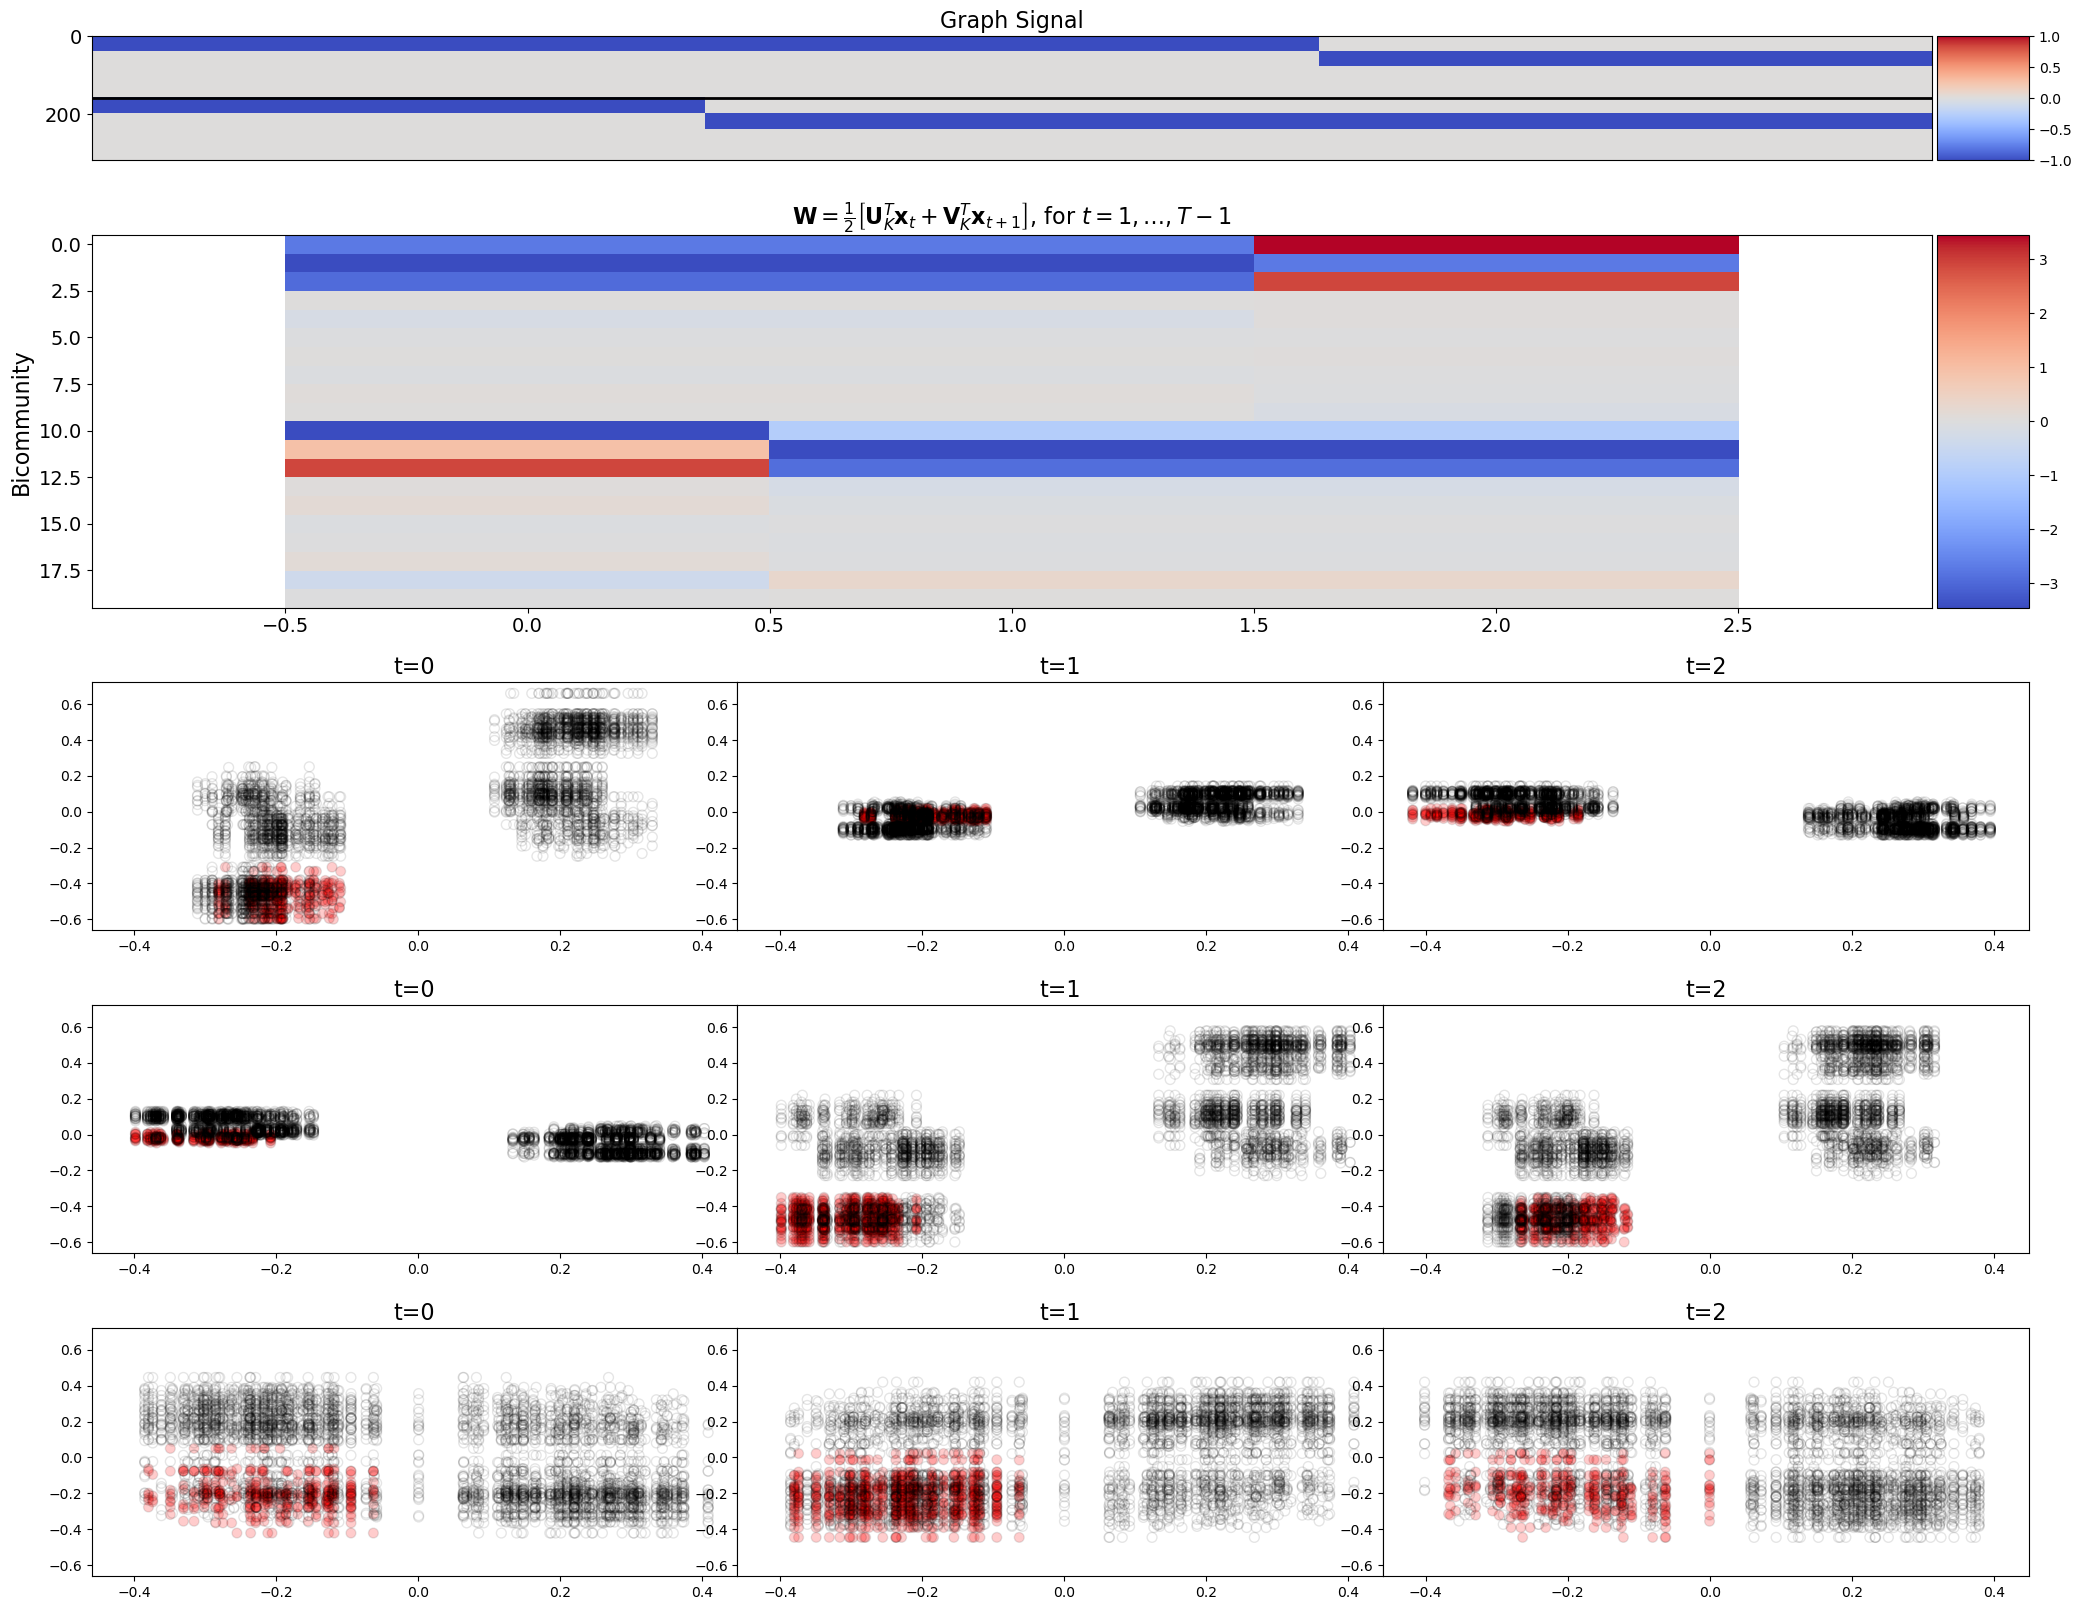

In [844]:
fig, axes = plt.subplots(nrows=5, figsize=(25, 20), gridspec_kw={"hspace":0.3, "height_ratios":[1, 3, 2, 2, 2]})

axes[0].set_title("Graph Signal", fontsize=16)
# axes[0].imshow(block_signal, aspect="auto", cmap="coolwarm", interpolation="none", vmin=-1, vmax=1)
axes[0].imshow(x_concat.T, aspect="auto", cmap="coolwarm", interpolation="none", vmin=-1, vmax=1)

# for k in range(7):
#     axes[0].hlines((k+1)*n_per_com-1, -0.5, 2*n_timepoints-1.5, color="k", linewidth=2)

axes[0].hlines(len(adj)-1, -0.5, 2*n_timepoints-1.5, color="k", linewidth=2)

axes[0].set_xticks([])
axes[0].tick_params(labelsize=14)
plot.add_cbar(fig, axes[0])

maxval = proj_signals.max()
minval = -maxval

axes[1].set_title("$\mathbf{W}=\\frac{1}{2}\left[\mathbf{U}^{T}_{K}\mathbf{x}_{t}+\mathbf{V}^{T}_{K}\mathbf{x}_{t+1}\\right]$"
                  ", for $t=1,\ldots,T-1$", fontsize=16)
ax = axes[1]
ax.imshow(proj_signals.T, cmap="coolwarm", vmin=minval, vmax=maxval, aspect="auto", interpolation="none")

ax.tick_params(labelsize=14)
# ax.set_xlabel("Time", fontsize=16)
ax.set_xlim(-0.9, 2*n_timepoints-1.1)
ax.set_ylabel("Bicommunity", fontsize=16)
plot.add_cbar(fig, ax)

max_com = np.argmax(b_vectors, axis=0)

circular_pos, graph_pos = plot.circular_layout(n_blocks, n_per_com, radius=2, small_radius=0.3, return_dict=True)

edge_prop = 0.3
net_red = [np.random.choice(n_per_com*n_blocks, int((1-edge_prop)*n_per_com*n_blocks), replace=False) for i in range(2)]

# axes[2].set_title("Bicommunities", fontsize=16)
axes[2].axis("off")
gs = GridSpecFromSubplotSpec(1, 2*n_timepoints-1, subplot_spec=axes[2], wspace=0)
axes_bicom = [fig.add_subplot(gs[0])]
axes_bicom += [fig.add_subplot(gs[i], sharex=axes_bicom[0], sharey=axes_bicom[0])
               for i in range(1, 2*n_timepoints-1)]

axes[3].axis("off")
gs = GridSpecFromSubplotSpec(1, 2*n_timepoints-1, subplot_spec=axes[3], wspace=0)
axes_bicom2 = [fig.add_subplot(gs[i], sharex=axes_bicom[0], sharey=axes_bicom[0])
               for i in range(2*n_timepoints-1)]

axes[4].axis("off")
gs = GridSpecFromSubplotSpec(1, 2*n_timepoints-1, subplot_spec=axes[4], wspace=0)
axes_bicom3 = [fig.add_subplot(gs[i], sharex=axes_bicom[0], sharey=axes_bicom[0])
               for i in range(2*n_timepoints-1)]

com_select = 0

for com_add, ax_list in enumerate([axes_bicom, axes_bicom2, axes_bicom3]):
    for i, ax in enumerate(ax_list):
        # ax.axis("off")
        ax.set_title(f"t={i}", fontsize=16)

        # red_mat = cluster_mat.copy().astype(float)
        # #red_mat[red_mat != max_com[i] + 1] = 0
        # for k in range(n_kmeans):
        #     red_mat[red_mat == k+1] *= b_vectors[k, i]

        # red_mat[np.abs(red_mat) < 0.1] = 0

        # red_mat[net_red[0], :] = 0
        # red_mat[:, net_red[1]] = 0

        # ax.scatter(circular_pos[0], circular_pos[1], s=20, color="silver")#, edgecolors="k", linewidths=1, zorder=2)
        ax.scatter(edge_assignments_vec[com_select+com_add, i], edge_assignments_vec[com_select+com_add+K, i], s=50,
                   edgecolors="k", alpha=0.1, linewidths=1, zorder=3, color="none")# c=sendreceive_sig_vec[i], cmap="binary_r")
        
        ax.scatter(edge_assignments_vec[com_select+com_add, i], edge_assignments_vec[com_select+com_add+K, i], s=50,
                   edgecolors="none", zorder=2, color="r", alpha=sendreceive_sig_vec[i]*0.2)
                # color="silver", edgecolors="k", linewidths=1, zorder=2, c=sendreceive_sig_vec, cmap="binary_r")
        # ax.plot(edge_assignments_vec[:, i])
    #     nx.draw_networkx_edges(nx.DiGraph(red_mat), pos=graph_pos, ax=ax, alpha=0.25)

(3, 20)
-2.718152023507374 -4.278403899081097


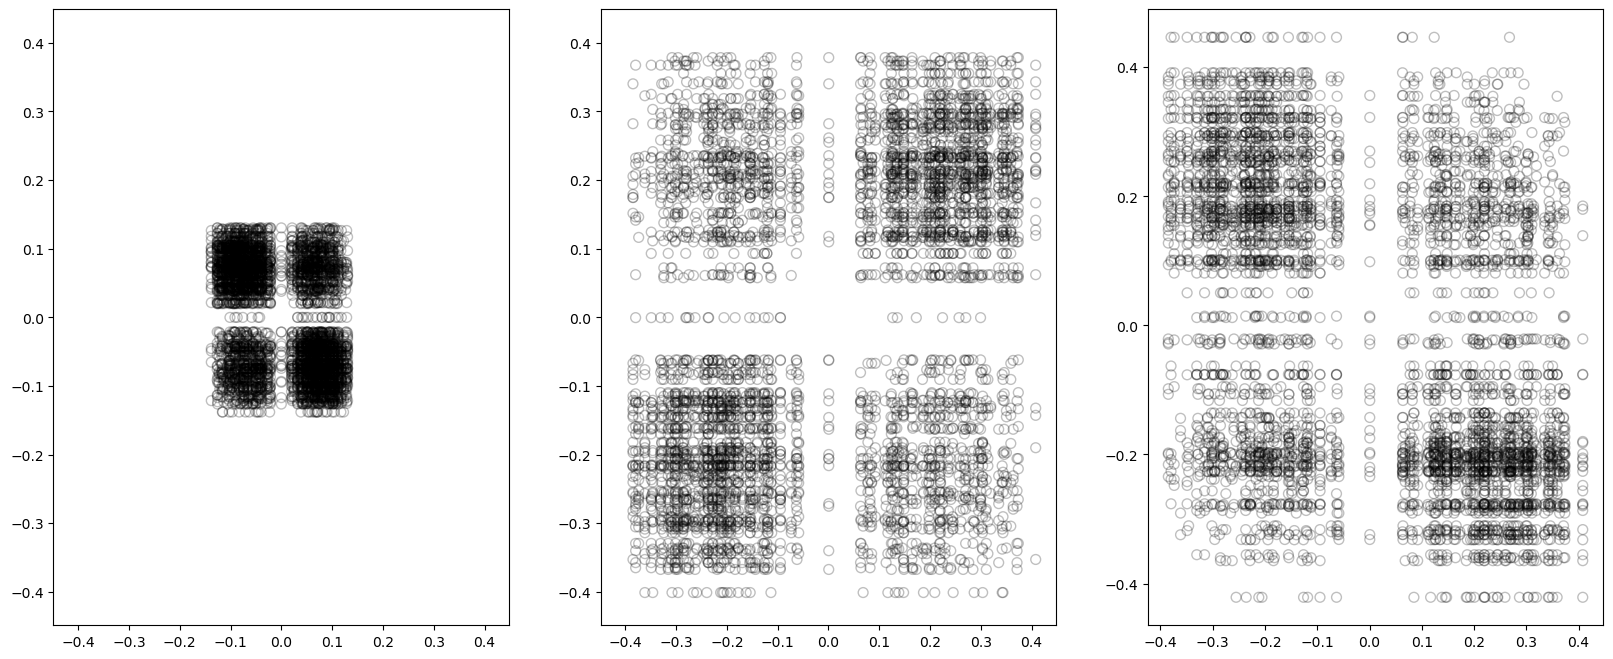

In [845]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 8))#, sharex=True, sharey=True)

com_select = 2

maxval = np.max([proj_signals[0, com_select]*orig_vec[com_select],
                 proj_signals[0, com_select + K]*orig_vec[com_select + K]])
maxval *= 1.1

axes[0].scatter(orig_vec[com_select], orig_vec[com_select + K], s=50,
                edgecolors="k", alpha=0.25, linewidths=1, zorder=3, color="none")# c=sendreceive_sig_vec[i], cmap="binary_r")

print(proj_signals.shape)
print(proj_signals[0, 0], proj_signals[0, K])

axes[1].scatter(proj_signals[0, com_select]*orig_vec[com_select],
                proj_signals[0, com_select+K]*orig_vec[com_select + K], s=50,
                edgecolors="k", alpha=0.25, linewidths=1, zorder=3, color="none")# c=sendreceive_sig_vec[i], cmap="binary_r")

axes[0].set_xlim(-maxval, maxval)
axes[0].set_ylim(-maxval, maxval)

axes[1].set_xlim(-maxval, maxval)
axes[1].set_ylim(-maxval, maxval)

axes[2].scatter(edge_assignments_vec[com_select, 0], edge_assignments_vec[com_select+K, 0], s=50,
                edgecolors="k", alpha=0.25, linewidths=1, zorder=3, color="none")# c=sendreceive_sig_vec[i], cmap="binary_r")

(20, 3, 4760)
(4760, 60)
Running silhouette analysis for k = 2 to 10 ...
Silhouette score for K=2 is : 0.330
Silhouette score for K=3 is : 0.402
Silhouette score for K=4 is : 0.484
Silhouette score for K=5 is : 0.491
Silhouette score for K=6 is : 0.508
Silhouette score for K=7 is : 0.587
Silhouette score for K=8 is : 0.664
Silhouette score for K=9 is : 0.626
Best average silhouette_score is : 0.66 for K=8


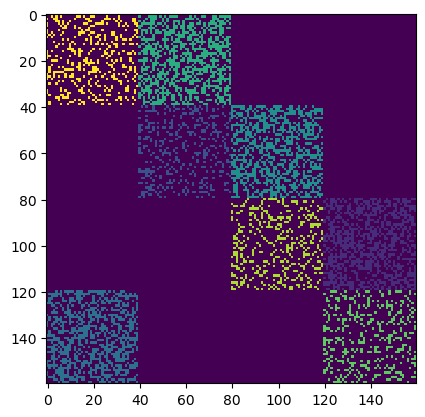

In [718]:
edge_feat = edge_assignments_vec.copy()
print(edge_assignments_vec.shape)
edge_feat = edge_feat.T
edge_feat = edge_feat.reshape((edge_feat.shape[0], -1))

print(edge_feat.shape)

n_kmeans = dgsp.get_best_k(edge_feat, verbose=True, max_k=10)
# n_kmeans = dgsp.get_best_k(edge_feat, verbose=True, max_k=2*n_timepoints)

kmeans = KMeans(n_clusters=n_kmeans, random_state=0, n_init="auto").fit(edge_feat)
edge_clusters = kmeans.labels_ + 1

n_clusters = edge_clusters.max()

cluster_mat = np.zeros_like(adj)
cluster_mat[adj != 0] = edge_clusters

plt.imshow(cluster_mat, interpolation="none")

In [705]:
# Temporal clustering

k_opt = dgsp.get_best_k(proj_signals, 2*n_timepoints-1, True)

kmeans = KMeans(n_clusters=k_opt)
kmeans.fit_transform(proj_signals)

kmeans.labels_

Running silhouette analysis for k = 2 to 3 ...
Silhouette score for K=2 is : 0.098
Best average silhouette_score is : 0.10 for K=2


array([0, 0, 1], dtype=int32)

## Finding the best $K$

In [662]:
x_concat = np.zeros((2*n_timepoints-1, 2*len(adj)))
print(x_concat.shape)
x_concat[::2] = np.concatenate([block_signal, block_signal], axis=0).T
x_concat[1::2] = np.concatenate([block_signal[:, :-1], block_signal[:, 1:]], axis=0).T

x_concat = x_concat - x_concat.mean(axis=1, keepdims=True)

proj_signals = np.array([C_pinv @ x_t for x_t in x_concat])

U, S, Vh = dgsp.sorted_SVD(dgsp.modularity_matrix(adj))
V = Vh.T

n_concat = len(adj)
n_concat = 50

all_n = np.arange(1, len(adj)+1)
all_losses = np.zeros(len(all_n))

for i, n_concat in enumerate(all_n):
    uk = U[:, :n_concat]
    vk = V[:, :n_concat]

    C_mat = np.block([[uk, np.zeros_like(vk)],
                    [np.zeros_like(uk), vk]])
    C_pinv = np.linalg.pinv(C_mat)

    proj_signals = np.array([C_pinv @ x_t for x_t in x_concat])
    reconstructions = np.array([C_mat @ proj for proj in proj_signals])

    all_losses[i] = np.linalg.norm(reconstructions - x_concat)

(3, 320)


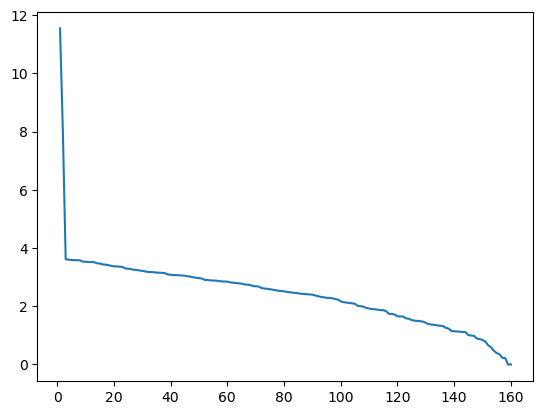

In [663]:
n_show = 200

plt.plot(all_n[:n_show], all_losses[:n_show])

## Undirected Case

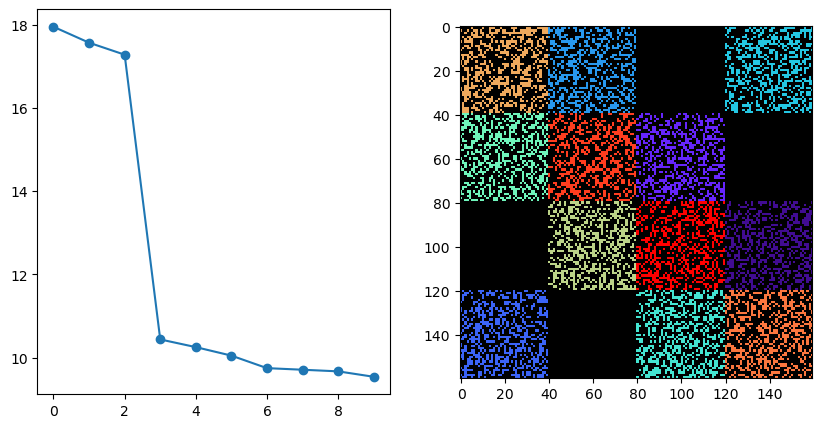

In [17]:
importlib.reload(dgsp)

n_per_com = 40
n_blocks = 4
com_density = 0.4
connect_density = 0.4

adj_sym = dgsp_graphs.block_cycle(n_per_com, n_blocks=n_blocks, com_density=com_density, connect_density=connect_density)
adj_sym = ((adj_sym + adj_sym.T) > 0).astype(int)

n_vec_max = 3
n_kmeans = 12

U_sym, S_sym, Vh = dgsp.sorted_SVD(dgsp.modularity_matrix(adj_sym))
V_sym = Vh.T

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].plot(S_sym[:10], marker="o")

C_mat_out, c_pinv_out, C_mat_in, c_pinv_in, bimod_idx, edge_clusters, cluster_mat = dgsp.get_c_pinv(adj_sym, n_vec_max, n_kmeans,
                                                                                                    normalize=False, verbose=False,
                                                                                                    return_clusters=True)

axes[1].imshow(cluster_mat, cmap=cmap_8clusters, interpolation="none")

(12, 16)


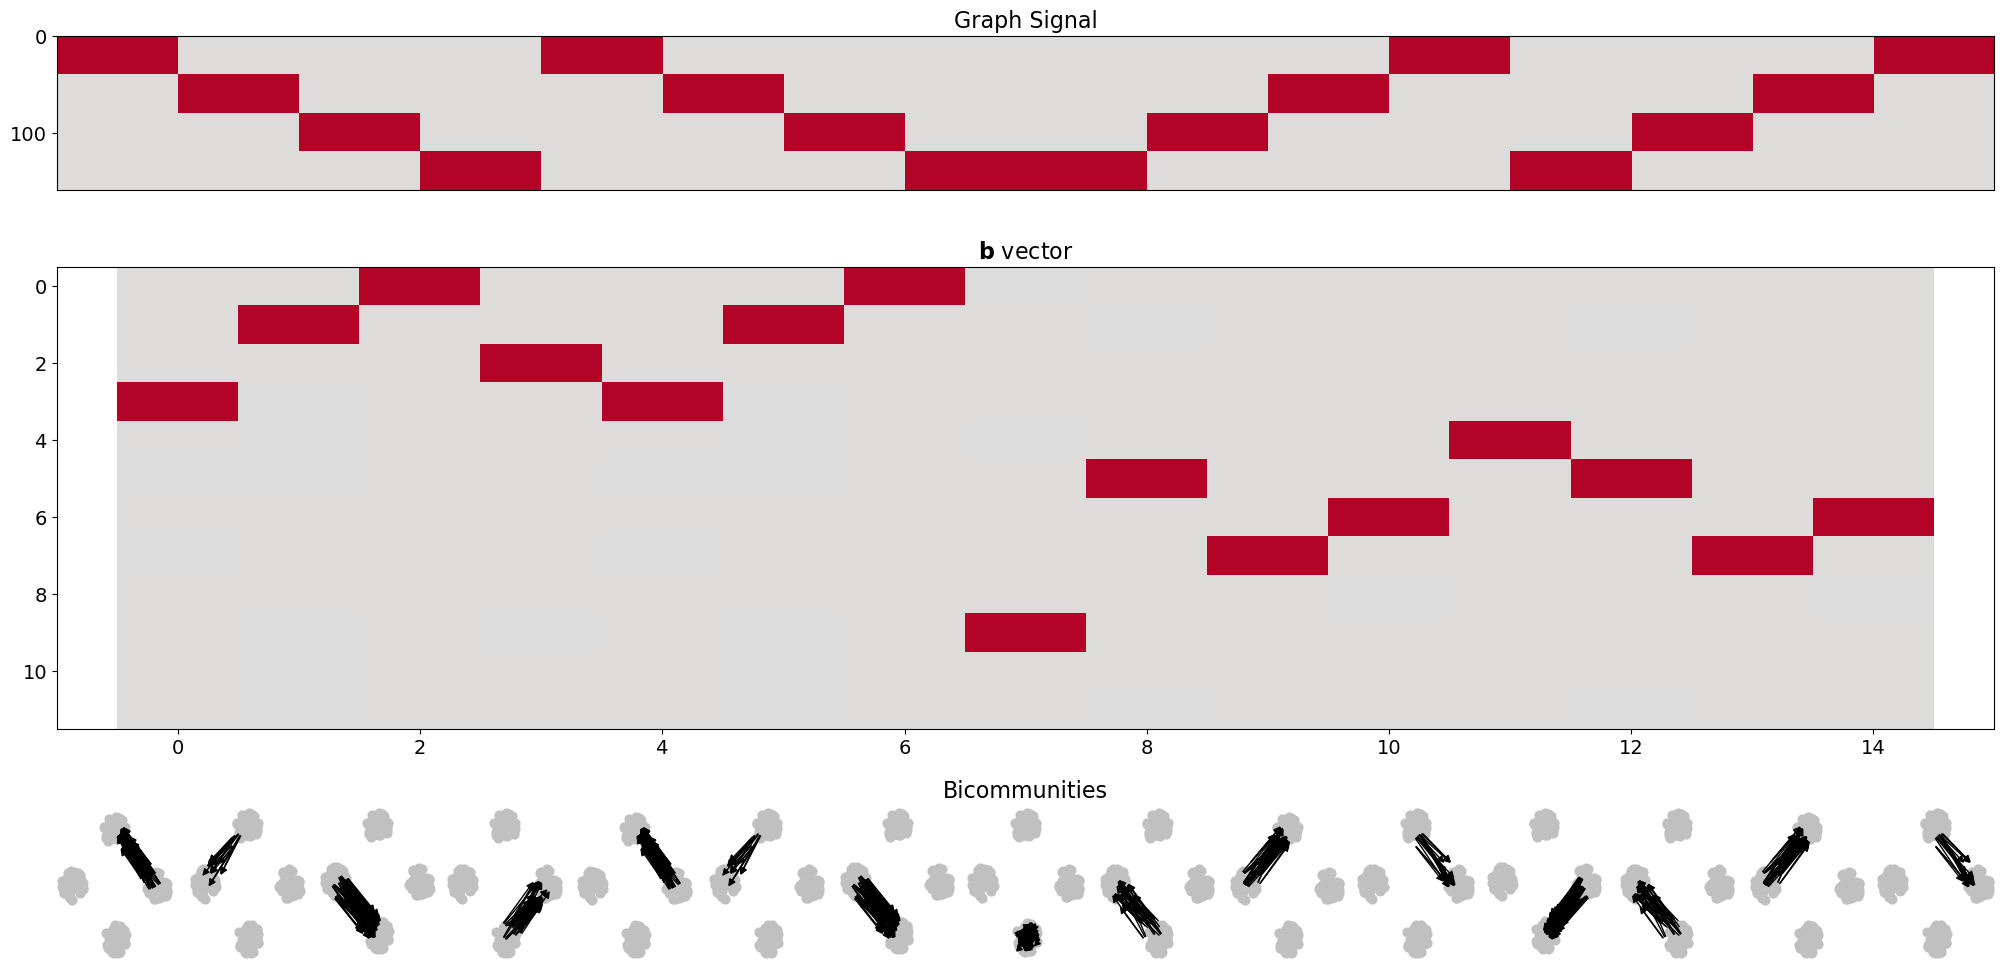

In [21]:
n_cycles = 4
n_timepoints = n_cycles*n_blocks

block_signal = np.zeros((n_per_com*n_blocks, n_timepoints))
for t in range(n_timepoints):
    block = t % n_cycles

    block_signal[n_per_com*(block):n_per_com*(block+1), t] = 1

block_signal[:, n_timepoints//2:] = np.flip(block_signal[:, :n_timepoints//2], axis=1)
W_out = (c_pinv_out @ block_signal)
print(W_out.shape)

b_vectors = np.zeros((n_kmeans, n_timepoints - 1))
for i, w_out in enumerate(W_out.T[:-1]):
    D_mat = C_mat_in @ np.diag(w_out)
    D_pinv = np.linalg.pinv(D_mat, rcond=1e-10)

    if np.linalg.norm(D_pinv) > 1e5:
        print(f"Warning: Large norm of D_pinv at timepoint {i} !")

    b_vectors[:, i] = D_pinv @ block_signal[:, i+1]

fig, axes = plt.subplots(nrows=3, figsize=(25, 12), gridspec_kw={"hspace":0.3, "height_ratios":[1, 3, 1]})

axes[0].set_title("Graph Signal", fontsize=16)
axes[0].imshow(block_signal, aspect="auto", cmap="coolwarm", interpolation="none", vmin=-1, vmax=1)
axes[0].set_xticks([])
axes[0].tick_params(labelsize=14)

maxval = np.log(b_vectors.max())
minval = -maxval

axes[1].set_title("$\mathbf{b}$ vector", fontsize=16)
ax = axes[1]
ax.imshow(b_vectors, cmap="coolwarm", vmin=minval, vmax=maxval, aspect="auto", interpolation="none")

ax.tick_params(labelsize=14)
# ax.set_xlabel("Time", fontsize=16)
ax.set_xlim(-1, n_timepoints-1)

axes[2].set_title("Bicommunities", fontsize=16)
axes[2].axis("off")
gs = GridSpecFromSubplotSpec(1, n_timepoints-1, subplot_spec=axes[2], wspace=0.1)
axes_bicom = [fig.add_subplot(gs[i]) for i in range(n_timepoints-1)]

max_com = np.argmax(b_vectors, axis=0)

circular_pos, graph_pos = plot.circular_layout(n_blocks, n_per_com, radius=2, small_radius=0.3, return_dict=True)

edge_prop = 0.3
net_red = [np.random.choice(n_per_com*n_blocks, int((1-edge_prop)*n_per_com*n_blocks), replace=False) for i in range(2)]

for i, ax in enumerate(axes_bicom):
    ax.axis("off")
    
    red_mat = cluster_mat.copy().astype(float)
    #red_mat[red_mat != max_com[i] + 1] = 0
    for k in range(n_kmeans):
        red_mat[red_mat == k+1] *= b_vectors[k, i]

    red_mat[np.abs(red_mat) < 0.1] = 0

    red_mat[net_red[0], :] = 0
    red_mat[:, net_red[1]] = 0

    ax.scatter(circular_pos[0], circular_pos[1], s=40, color="silver")#, edgecolors="k", linewidths=1, zorder=2)
    nx.draw_networkx_edges(nx.DiGraph(red_mat), pos=graph_pos, ax=ax)

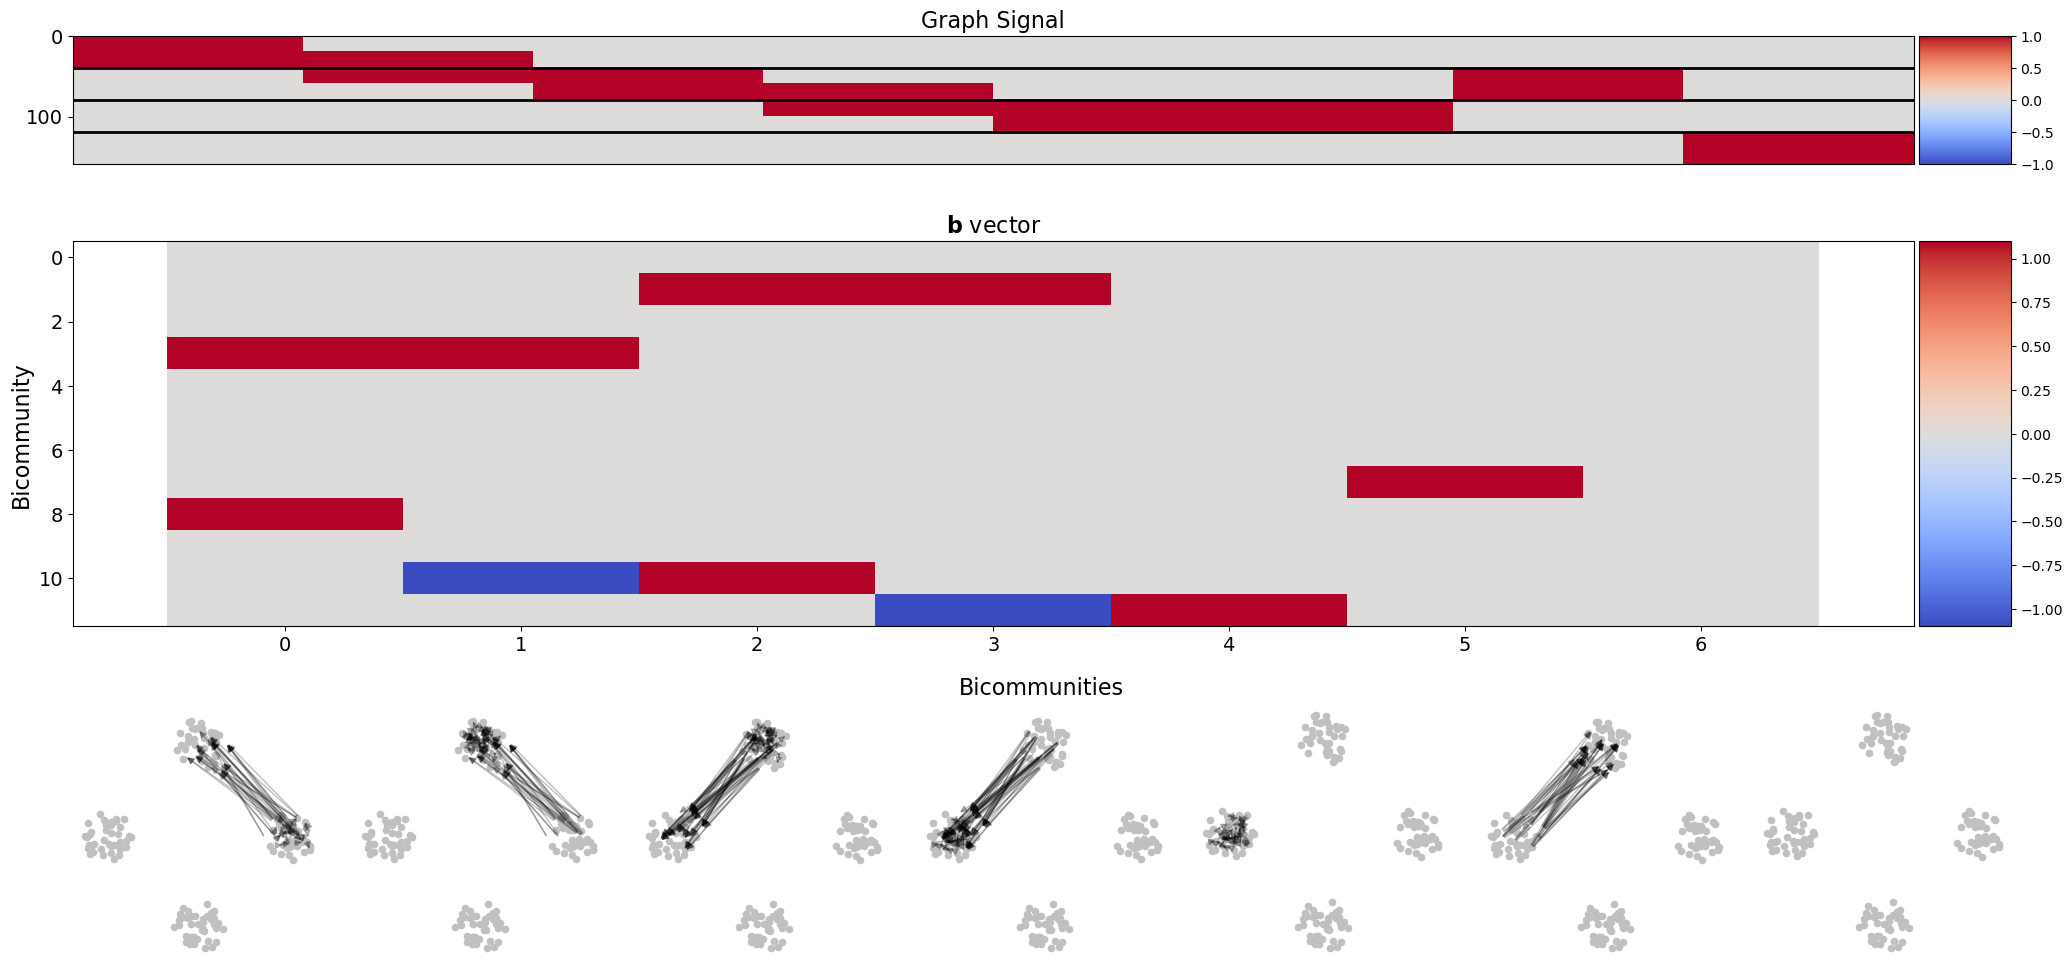

In [24]:
n_cycles = 2
overlap = 2

n_timepoints = overlap*n_cycles*n_blocks

block_signal = np.zeros((n_per_com*n_blocks, n_timepoints))
for t in range(n_timepoints):
    block = t % (overlap*n_cycles)

    block_signal[n_per_com//overlap*(block):n_per_com//overlap*(block+overlap), t] = 1

block_signal = np.insert(block_signal, 4, np.roll(block_signal[:, 0], 2*n_per_com), axis=1)
block_signal = np.insert(block_signal, 4, np.roll(block_signal[:, 0], 2*n_per_com), axis=1)
block_signal = np.insert(block_signal, 6, np.roll(block_signal[:, 0], 1*n_per_com), axis=1)
block_signal = np.insert(block_signal, 7, np.roll(block_signal[:, 0], 3*n_per_com), axis=1)

block_signal = block_signal[:, :8]

n_timepoints = len(block_signal[0])

W_out = (c_pinv_out @ block_signal)

b_vectors = np.zeros((n_kmeans, n_timepoints - 1))
for i, w_out in enumerate(W_out.T[:-1]):
    D_mat = C_mat_in @ np.diag(w_out)
    D_pinv = np.linalg.pinv(D_mat, rcond=1e-10)

    if np.linalg.norm(D_pinv) > 1e5:
        print(f"Warning: Large norm of D_pinv at timepoint {i} !")

    b_vectors[:, i] = D_pinv @ block_signal[:, i+1]

fig, axes = plt.subplots(nrows=3, figsize=(25, 12), gridspec_kw={"hspace":0.3, "height_ratios":[1, 3, 2]})

axes[0].set_title("Graph Signal", fontsize=16)
axes[0].imshow(block_signal, aspect="auto", cmap="coolwarm", interpolation="none", vmin=-1, vmax=1)

for k in range(3):
    axes[0].hlines((k+1)*n_per_com-1, -0.5, n_timepoints-0.5, color="k", linewidth=2)

axes[0].set_xticks([])
axes[0].tick_params(labelsize=14)
plot.add_cbar(fig, axes[0])

maxval = np.log(b_vectors.max())
minval = -maxval

axes[1].set_title("$\mathbf{b}$ vector", fontsize=16)
ax = axes[1]
ax.imshow(b_vectors, cmap="coolwarm", vmin=minval, vmax=maxval, aspect="auto", interpolation="none")

ax.tick_params(labelsize=14)
# ax.set_xlabel("Time", fontsize=16)
ax.set_xlim(-0.9, n_timepoints-1.1)
ax.set_ylabel("Bicommunity", fontsize=16)
plot.add_cbar(fig, ax)

axes[2].set_title("Bicommunities", fontsize=16)
axes[2].axis("off")
gs = GridSpecFromSubplotSpec(1, n_timepoints-1, subplot_spec=axes[2], wspace=0.1)
axes_bicom = [fig.add_subplot(gs[i]) for i in range(n_timepoints-1)]

max_com = np.argmax(b_vectors, axis=0)

circular_pos, graph_pos = plot.circular_layout(n_blocks, n_per_com, radius=2, small_radius=0.3, return_dict=True)

edge_prop = 0.3
net_red = [np.random.choice(n_per_com*n_blocks, int((1-edge_prop)*n_per_com*n_blocks), replace=False) for i in range(2)]

for i, ax in enumerate(axes_bicom):
    ax.axis("off")
    
    red_mat = cluster_mat.copy().astype(float)
    #red_mat[red_mat != max_com[i] + 1] = 0
    for k in range(n_kmeans):
        red_mat[red_mat == k+1] *= b_vectors[k, i]

    red_mat[np.abs(red_mat) < 0.1] = 0

    red_mat[net_red[0], :] = 0
    red_mat[:, net_red[1]] = 0

    ax.scatter(circular_pos[0], circular_pos[1], s=20, color="silver")#, edgecolors="k", linewidths=1, zorder=2)
    nx.draw_networkx_edges(nx.DiGraph(red_mat), pos=graph_pos, ax=ax, alpha=0.25)